Part of [Neural Network Notebook (3nb)](http://ekaakurniawan.github.io/3nb/) project.

> Copyright (C) 2014  Eka A. Kurniawan
>
> eka.a.kurniawan(ta)gmail(tod)com
>
> This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
>
> This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
>
> You should have received a copy of the GNU General Public License along with this program.  If not, see <http://www.gnu.org/licenses/>.

### TODOs

- __Memory Consumption__: Calculate memory consumption for different neuron sizes and number of iterations.

Done:

- __Execution Time__: Add save/load execution time result into/from file.
- __Workitem Sizes Run Time__: Perform experiment with different local work size to produce the best run time.
- __Code__: Modify OpenCL single element parameters as single element instead of array.
- __Execution Time__: Add reference to the lack of global barrier function.
- __Execution Time__: Add number of neurons segmentation (one thousand, tens of thousands and one million) based on global barrier, device types, maximum workgroup size, and memory size to the faster runtime.
- __Execution Time__: Collect execution time of 1 million neurons.
- __Execution Time__: Handle 0.0 second runtimes in log plot by setting them to Y axis lower limit.
- __Execution Time__: Add device specifications and machine information.
- __Execution Time__: Collect runtime using one workgroup.

### Tested On

In [1]:
import sys
print("Python %d.%d.%d" % (sys.version_info.major, \
                           sys.version_info.minor, \
                           sys.version_info.micro))

Python 3.5.2


In [2]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.11.2


In [3]:
# Display graph inline
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib %s" % matplotlib.__version__)

matplotlib 1.5.1


### Display Settings

In [4]:
# Display graph in 'retina' format for Mac with retina display. Others, use PNG or SVG format.
%config InlineBackend.figure_format = 'retina'
#%config InlineBackend.figure_format = 'PNG'
#%config InlineBackend.figure_format = 'SVG'

### Imports

In [5]:
import time
import os.path

### Housekeeping Functions

Functions to save/load array to/from file.

In [6]:
def save_list(file_name, list_name):
    with open(file_name, 'w') as fh:
        fh.write("\n".join(list_name))
    
def load_list(file_name):
    with open(file_name, 'r') as fh:
        return [line.strip() for line in fh.readlines()]

Following function plots injected current, membrance voltage and occuring spikes in a same graph.

In [7]:
# dt: time step in second
# Iinjects: array of injected current every time step in ampere
# Vms: array of membrane potentials every time step in voltage
# spikes: array of simulation times when spikes happen
def plot_spikes(dt, Iinjects, Vms, spikes):
    # Convert Iinjects from Ampere to Nanoampere
    Iinjects_prime = Iinjects * 1e9
    # Convert Vms from Volt to Millivolt
    Vms_prime = Vms * 1e3
    
    fig = plt.figure()
    
    len_Iinjects = len(Iinjects)
    time = np.linspace(0,len_Iinjects-1,len_Iinjects) * dt
    
    sp1 = fig.add_subplot(311)
    sp1.fill_between(time, 0, Iinjects_prime, color = 'green')
    sp1.set_ylabel("Injected\nCurrent\n(Nanoamperes)")
    sp1.grid(True)
    sp1.yaxis.tick_right()
    plt.setp(sp1.get_xticklabels(), visible = False)
    
    sp2 = fig.add_subplot(312)
    sp2.plot(time, Vms_prime, color = 'blue')
    sp2.set_ylabel('Membrane\nVoltage\n(Millivolts)')
    sp2.grid(True)
    sp2.yaxis.tick_right()
    plt.setp(sp2.get_xticklabels(), visible = False)
    
    sp3 = fig.add_subplot(313)
    sp3.scatter(spikes, len(spikes) * [1], color = 'red')
    sp3.set_ylabel('Spikes')
    sp3.set_xlabel('Time (Seconds)')
    sp3.xaxis.grid()
    plt.setp(sp3.get_yticklabels(), visible = False)
    plt.setp(sp3.get_yaxis(), ticks = [])
    
    plt.xlim([0, time[-1]])
    plt.show()

Following function plots execution time comprises buffer allocation time (`bat`), run time (`rt`), result collection time (`rct`) and the total time (`tt`) of the three.

In [8]:
def plot_exec_time(bats, rts, rcts, tts, device_names, \
                   methods_len, \
                   SEQ_ID, PAR_PLIR_ID, PAR_PLCR_ID, PAR_CLCR_ID, \
                   PAR_PLCR_PA_ID, PAR_CLCR_PA_ID, PAR_CLCRWG_PA_ID, \
                   ttl_neurons):
    
    # Set lower and upper limits for X and Y axis.
    xlim_lower = 1
    xlim_upper = 1e6
    ylim_lower = 1e-4
    ylim_upper = 1e4
    
    portions = [bats, rts, rcts, tts]
    portions_len = len(portions)
    portion_labels = ["Buffer Allocation Time", \
                      "Run Time", \
                      "Result Collection Time", \
                      "Total Time"]
    devices_len = len(device_names)
    fig, axs = plt.subplots(portions_len, devices_len, sharey = True)
    # axs will be accessed in two-dimentional form. If it is in one-dimentional
    # (in case of devices_len equals one) add one more fake dimention to it.
    if (devices_len <= 1):
        axs_ext = np.array(portions_len * [np.nan])
        axs = np.vstack((axs, axs_ext)).transpose()
    # Figure size
    fig.set_size_inches(27, 27)
    
    # Colors
    colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'orange', 'gray']
    # Plot
    for portion_id, portion in enumerate(portions):
        for device_id, device_name in enumerate(device_names):
            # Title
            axs[portion_id, device_id].set_title(device_names[device_id])
            # Handle logarithmic along X or Y axis
            axs[portion_id, device_id].set_xscale('log')
            axs[portion_id, device_id].set_yscale('log')
            # Set lower and upper limits for X and Y axis.
            axs[portion_id, device_id].set_xlim(xlim_lower, xlim_upper)
            axs[portion_id, device_id].set_ylim(ylim_lower, ylim_upper)
            axs[portion_id, device_id].grid(True)
            
            if not np.isnan(portions[portion_id][device_id][SEQ_ID][0]):
                time_values = [ylim_lower if time_value == 0 else time_value \
                               for time_value in portions[portion_id][device_id][SEQ_ID]]
                axs[portion_id, device_id].plot(ttl_neurons, time_values, \
                                                label = "seq", \
                                                color = colors[SEQ_ID], \
                                                linewidth = 2.5)
            if not np.isnan(portions[portion_id][device_id][PAR_PLIR_ID][0]):
                time_values = [ylim_lower if time_value == 0 else time_value for \
                               time_value in portions[portion_id][device_id][PAR_PLIR_ID]]
                axs[portion_id, device_id].plot(ttl_neurons, time_values, \
                                                label = "par_plir", \
                                                color = colors[PAR_PLIR_ID], \
                                                linewidth = 2.5)
            if not np.isnan(portions[portion_id][device_id][PAR_PLCR_ID][0]):
                time_values = [ylim_lower if time_value == 0 else time_value for \
                               time_value in portions[portion_id][device_id][PAR_PLCR_ID]]
                axs[portion_id, device_id].plot(ttl_neurons, time_values, \
                                                label = "par_plcr", \
                                                color = colors[PAR_PLCR_ID], \
                                                linewidth = 2.5)
            if not np.isnan(portions[portion_id][device_id][PAR_PLCR_PA_ID][0]):
                time_values = [ylim_lower if time_value == 0 else time_value for \
                               time_value in portions[portion_id][device_id][PAR_PLCR_PA_ID]]
                axs[portion_id, device_id].plot(ttl_neurons, time_values, \
                                                label = "par_plcr_pa", \
                                                color = colors[PAR_PLCR_PA_ID], \
                                                linewidth = 2.5)
            if not np.isnan(portions[portion_id][device_id][PAR_CLCR_ID][0]):
                time_values = [ylim_lower if time_value == 0 else time_value for \
                               time_value in portions[portion_id][device_id][PAR_CLCR_ID]]
                axs[portion_id, device_id].plot(ttl_neurons, time_values, \
                                                label = "par_clcr", \
                                                color = colors[PAR_CLCR_ID], \
                                                linewidth = 2.5)
            if not np.isnan(portions[portion_id][device_id][PAR_CLCR_PA_ID][0]):
                time_values = [ylim_lower if time_value == 0 else time_value for \
                               time_value in portions[portion_id][device_id][PAR_CLCR_PA_ID]]
                axs[portion_id, device_id].plot(ttl_neurons, time_values, \
                                                label = "par_clcr_pa", \
                                                color = colors[PAR_CLCR_PA_ID], \
                                                linewidth = 2.5)
            if not np.isnan(portions[portion_id][device_id][PAR_CLCRWG_PA_ID][0]):
                time_values = [ylim_lower if time_value == 0 else time_value for \
                               time_value in portions[portion_id][device_id][PAR_CLCRWG_PA_ID]]
                axs[portion_id, device_id].plot(ttl_neurons, time_values, \
                                                label = "par_clcrwg_pa", \
                                                color = colors[PAR_CLCRWG_PA_ID], \
                                                linewidth = 2.5)
            
            # X Labels
            axs[portion_id, device_id].set_xlabel('# Neurons', fontsize = 14)
            # Legend
            axs[portion_id, device_id].legend(loc = 'upper left')
            # Tick font size
            for tick in axs[portion_id, device_id].xaxis.get_major_ticks():
                tick.label.set_fontsize(12)
            for tick in axs[portion_id, device_id].yaxis.get_major_ticks():
                tick.label.set_fontsize(12)

        # Y Labels
        axs[portion_id, 0].set_ylabel(portion_labels[portion_id] + '\n(second)', \
                                      fontsize = 14)
    
    plt.show()

Following function plots iteration run time.

In [9]:
def plot_iter_time(seq_it_rts, par_it_rts, device_names, ttl_iterations):
    
    fig = plt.figure()
    sp1 = fig.add_subplot(111)
    
    # Handle logarithmic along X or Y axis
    sp1.set_xscale('log')
    sp1.set_yscale('log')
    sp1.grid(True)
    
    # Plot sequential
    sp1.plot(ttl_iterations, seq_it_rts, \
             label = 'Seq', color = 'red', \
             linewidth = 2.5)
    # Plot parallel
    colors = ['green', 'blue', 'magenta']
    for device_id, device_name in enumerate(device_names):
        sp1.plot(ttl_iterations, par_it_rts[device_id], \
                 label = "Par - " + device_name, color = colors[device_id], \
                 linewidth = 2.5)
    
    # X and Y labels
    sp1.set_xlabel('# Iterations')
    sp1.set_ylabel('Runtime (second)')
    # Legend
    sp1.legend(loc = 'upper left')
    
    plt.ylim([1e-4, 1e8])
    plt.show()

Following function plots run time based on different workitem sizes.

In [10]:
def plot_workitem_size_runtime(par_ws_rts, device_names, workitem_sizes):
    
    fig = plt.figure()
    sp1 = fig.add_subplot(111)
    sp1.grid(True)
    
    # Plot parallel
    colors = ['green', 'blue', 'magenta']
    for device_id, device_name in enumerate(device_names):
        sp1.plot(par_ws_rts[device_id], \
                 label = device_name, color = colors[device_id], \
                 linewidth = 2.5)
    
    # X tick label
    sp1.set_xticklabels(list(map(str, workitem_sizes)))
    # X and Y labels
    sp1.set_xlabel('Workitem Size')
    sp1.set_ylabel('Runtime (second)')
    # Legend
    sp1.legend(loc = 'upper right')
    
    plt.ylim([0, 3])
    plt.show()

---

# Leaky Integrate-and-Fire (LIF) Neuron Model

Following figure shows cell membrane equivalent parallel RC circuit.

<center><br>
<img src="https://raw.github.com/ekaakurniawan/3nb/master/Neuron%20Models/LifNeuron/Images/Equivalent%20Parallel%20RC%20Circuit.png" width=300 />
<br>
<i>Cell Membrane Equivalent Parallel RC Circuit</i>
</center><br>

Following equation is the general formula for the equivalent circuit based on Kirchhoff's Current Law (KCL).

$$C_m\frac{dV_m}{dt} + \frac{V_m - V_{resting}}{R_m} = I_m$$

or

$$C_m\frac{dV_m}{dt} = -\frac{V_m - V_{resting}}{R_m} + I_m$$

Multiply by $R_m$.

$$R_mC_m\frac{dV_m}{dt} = -\big(V_m - V_{resting}\big) + R_mI_m$$

or

$$R_mC_m\frac{dV_m}{dt} = -V_m + V_{resting} + R_mI_m$$

Convert $R_mC_m$ into membrane time constant ($\tau_m$).

$$\tau_m\frac{dV_m}{dt} = -V_m + V_{resting} + R_mI_m$$

Current that passes through membrane ($I_m$) consists of active synaptic current ($I_{syn}(t)$) and passive current like injected current ($I_{inject}$) for experimental purposes and current that keeps cell membrane at resting potential ($V_{resting}$) called resting current ($I_{resting}$).

Adding the additional currents and applying $V_{resting} = R_mI_{resting}$, we get:

$$\tau_m\frac{dV_m}{dt} = -V_m + R_m\big(I_{syn}(t) + I_{resting} + I_{inject}\big)$$

Use following first-order exponential integrator method to solve previous equation.[1]

> Equation:
>
> $y'(t) = -Ay + \mathcal{N}(y)$
> 
> Numerical solution in which $\mathcal{N}\big(y(t_n)\big)$ is treated as constant:
>
> $y_{n+1} = e^{-Ah}y_n + \displaystyle{\int_0^h} e^{-(h-t_n)A}\mathcal{N}\big(y(t_n)\big)dt_n$
> $\Longrightarrow$ 
> $y_{n+1} = e^{-Ah}y_n + A^{-1}\big(1-e^{-Ah}\big)\mathcal{N}\big(y(t_n)\big)$

Rewriting the differential equation.

$$\frac{dV_m}{dt} = -\frac{1}{\tau_m}V_m + \frac{R_m}{\tau_m}\big(I_{syn}(t) + I_{resting} + I_{inject}\big)$$

or

$$\frac{dV_m}{dt} = -\frac{1}{\tau_m}V_m + \frac{1}{C_m}\big(I_{syn}(t) + I_{resting} + I_{inject}\big)$$

Matching components.

> $$y'(t) = \frac{dV_m}{dt}$$
> 
> $$A = \frac{1}{\tau_m} $$
> 
> $$y = V_m$$
> 
> $$\mathcal{N}(y) = \frac{1}{C_m}\big(I_{syn}(t) + I_{resting} + I_{inject}\big)$$
> 
> $$h= dt$$

The solution.

$$V_{m_{n+1}} = e^{-\frac{dt}{\tau_m}}V_{m_n} + \tau_m\big(1-e^{-\frac{dt}{\tau_m}}\big)\frac{1}{C_m}\big(I_{syn}(t) + I_{resting} + I_{inject}\big)$$

or

$$V_{m_{n+1}} = e^{-\frac{dt}{\tau_m}}V_{m_n} + R_m\big(1-e^{-\frac{dt}{\tau_m}}\big)\big(I_{syn}(t) + I_{resting} + I_{inject}\big)$$

On the following code implementation, constants are pre-calculated as $C_1$ and $C_2$. Where $C_1 = e^{-\frac{dt}{\tau_m}}$ and $C_2 = R_m\big(1-e^{-\frac{dt}{\tau_m}}\big)$.

Summation point sums up all currents in a neuron. $sumattionPoint = \big(I_{syn}(t) + I_{resting} + I_{inject}\big)$.

The final formula is as follow.

$$V_{m_{n+1}} = C_1.V_{m_n} + C_2.sumattionPoint$$

Following is `LifNeuron` class to simulate Leaky Integrate-and-Fire (LIF) neuron model. `updateInternal` function pre-calculates constants like time constant (`tau`), $C_1$(`C1`) and $C_2$(`C2`). `nextState` function simulates membrane potential (Vm) and action potential (`hasFired`) of the neuron. The implementation is taken from CSIM: A neural Circuit SIMulator website and modified accordingly.[2]

In [11]:
from math import exp

class LifNeuron:
    def __init__(self,
                 dt = 2e-4,
                 Cm = 3e-8,
                 Rm = 1e6,
                 Vresting = -0.06,
                 Vthresh = None,
                 Vreset = None,
                 Vinit = None,
                 Vm = None,
                 Trefract = 3e-3,
                 Iinject = 0.0,
                 summationPoint = 0.0):
        self.Cm = Cm
        self.Rm = Rm
        self.Vresting = Vresting
        if Vthresh != None:
            self.Vthresh = Vthresh
        else:
            self.Vthresh = Vresting + 0.015
        if Vreset != None:
            self.Vreset = Vreset
        else:
            self.Vreset = self.Vresting
        if Vinit != None:
            self.Vinit = Vinit
        else:
            self.Vinit = self.Vreset
        if Vm != None:
            self.Vm = Vm
        else:
            self.Vm = self.Vinit
        self.Trefract = Trefract
        self.Isyn = summationPoint
        self.Iinject = Iinject
        self.summationPoint = summationPoint
        
        self.nStepsInRefr = 0
        
        self.tau = 0.0
        self.C1 = 0.0
        self.C2 = 0.0
        self.hasFired = 0
        self.updateInternal(dt)
        
    def updateInternal(self, dt = 2e-4):
        self.tau = self.Cm * self.Rm
        
        if self.tau > 0.0:
            self.C1 = exp(-dt / self.tau)
            self.C2 = self.Rm * (1.0 - self.C1)
        else:
            self.C1 = 0.0
            self.C2 = self.Rm
    
    def reset(self):
        self.Vm = self.Vinit
        self.nStepsInRefr = 0
        self.summationPoint = 0.0
        
    def nextState(self, dt = 2e-4):
        Isyn = self.summationPoint
        if (self.nStepsInRefr > 0):
            self.nStepsInRefr -= 1
            self.hasFired = 0
        elif (self.Vm >= self.Vthresh):
            self.hasFired = 1;
            self.nStepsInRefr = int((self.Trefract / dt) + 0.5)
            self.Vm = self.Vreset
        else:
            self.hadFired = 0
            self.summationPoint = self.Isyn + \
                                  (self.Vresting / self.Rm) + \
                                  self.Iinject
            self.Vm = (self.C1 * self.Vm) + (self.C2 * self.summationPoint)
        
        self.summationPoint = 0.0
        return self.Vm

Following code simulates LIF neuron with time step (`dt`) of 0.2 millisecond and injected current (`Iinjects`) of 20 nanoamperes in between. Initial voltage (`Vinit`), reset voltage (`Vrest`) and refractory period (`Trefract`) are set accordingly to show;

* exponentially decreasing membrane potential approacing resting potential at -60 millivolts in between 0 and 0.1 second,
* exponentially increasing membrane potential due to injected current starting from 0.1 second,
* an action potential at araound 0.14 second when membrane potential reaching -45 millivolts before being reset to -70 millivolts,
* refractory period happening right after an action potential, and
* finally, the membrane potential increasing exponentially back to the resting potential without injected current.

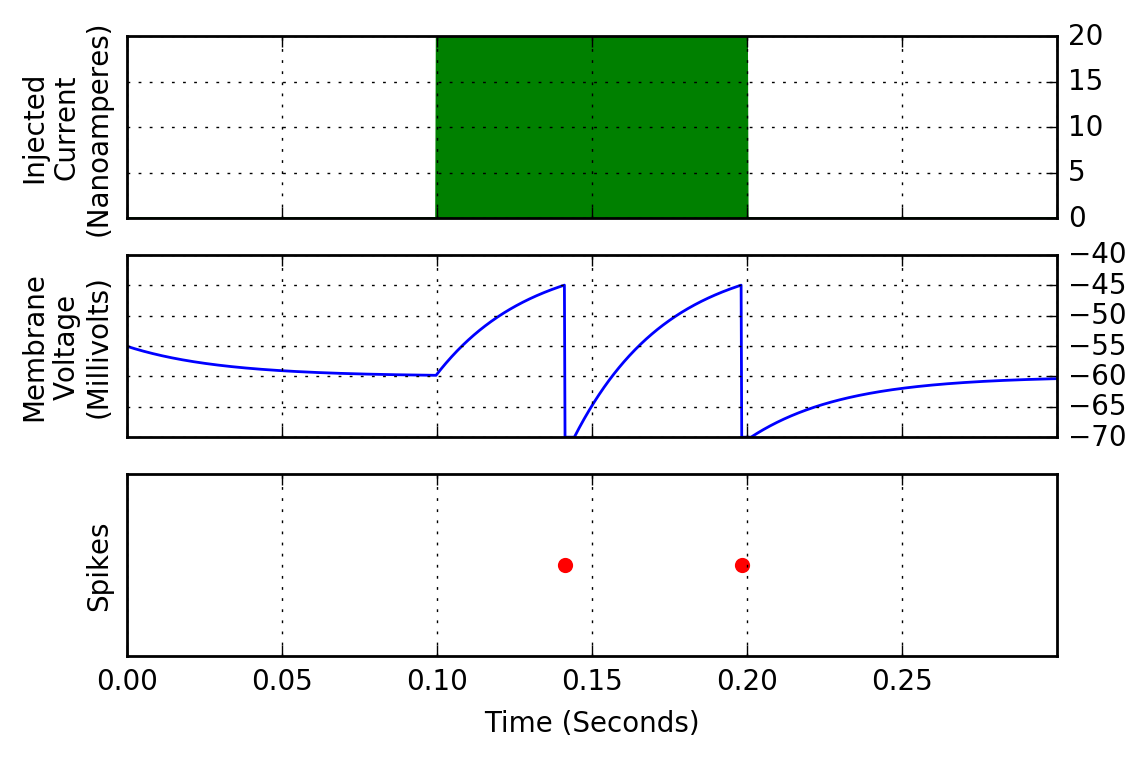

In [12]:
dt = 2e-4

Iinjects1 = 500 * [0.0]
Iinjects2 = 500 * [2e-8]
Iinjects3 = 500 * [0.0]

Iinjects = np.hstack([Iinjects1, Iinjects2, Iinjects3])
input_len = len(Iinjects)

n1 = LifNeuron(Vinit = -0.055, Vreset = -0.07, Trefract = 3e-3)
Vms = np.zeros(input_len)
spikes = []
for i in range(input_len):
    n1.Iinject = Iinjects[i]
    Vms[i] = n1.nextState(dt)
    if n1.hasFired:
        spikes.append(i * dt)
plot_spikes(dt, Iinjects, Vms, spikes)

---

# Sequential Python Implementation

### Sequential (`seq` Function)

Sequential function collects run time (`rt`) based on different numbers of neurons (`ttl_neuron`) is done entirely in Python. The difference of each neuron is the refractory period as it is getting longer and longer. This function is specifically designed so that the later neurons have only one spike instead of two. If plot parameter (`plot`) is set to be `True`, the function will plot the fist and last neuron's membrane potentials and spikes.

In [13]:
def run_seq(dt, Iinjects, ttl_neuron, plot = False):
    # Buffer allocation time and result collection time are all N/A
    bat = np.nan
    rct = np.nan
    
    input_len = len(Iinjects)
    
    trefracts = np.linspace(3e-3, 9e-3, ttl_neuron)
    lifNeurons = []
    for i in range(ttl_neuron):
        lifNeurons.append(LifNeuron(Vinit = -0.055, Vreset = -0.07, Trefract = trefracts[i]))
    
    Vms = np.zeros((ttl_neuron, input_len))
    spikes = [[] for i in range(ttl_neuron)]
    tic = time.time()
    for j in range(input_len):
        for i in range(ttl_neuron):
            lifNeurons[i].Iinject = Iinjects[j]
            Vms[i,j] = lifNeurons[i].nextState(dt)
            if lifNeurons[i].hasFired:
                spikes[i].append(j * dt)
    toc = time.time()
    # Run time
    rt = toc - tic
    # Total time
    tt = rt

    if plot:
        plot_spikes(dt, Iinjects, Vms[0], spikes[0])
        plot_spikes(dt, Iinjects, Vms[-1], spikes[-1])
    
    return bat, rt, rct, tt

Testing code for sequential function plots the first and last neurons.

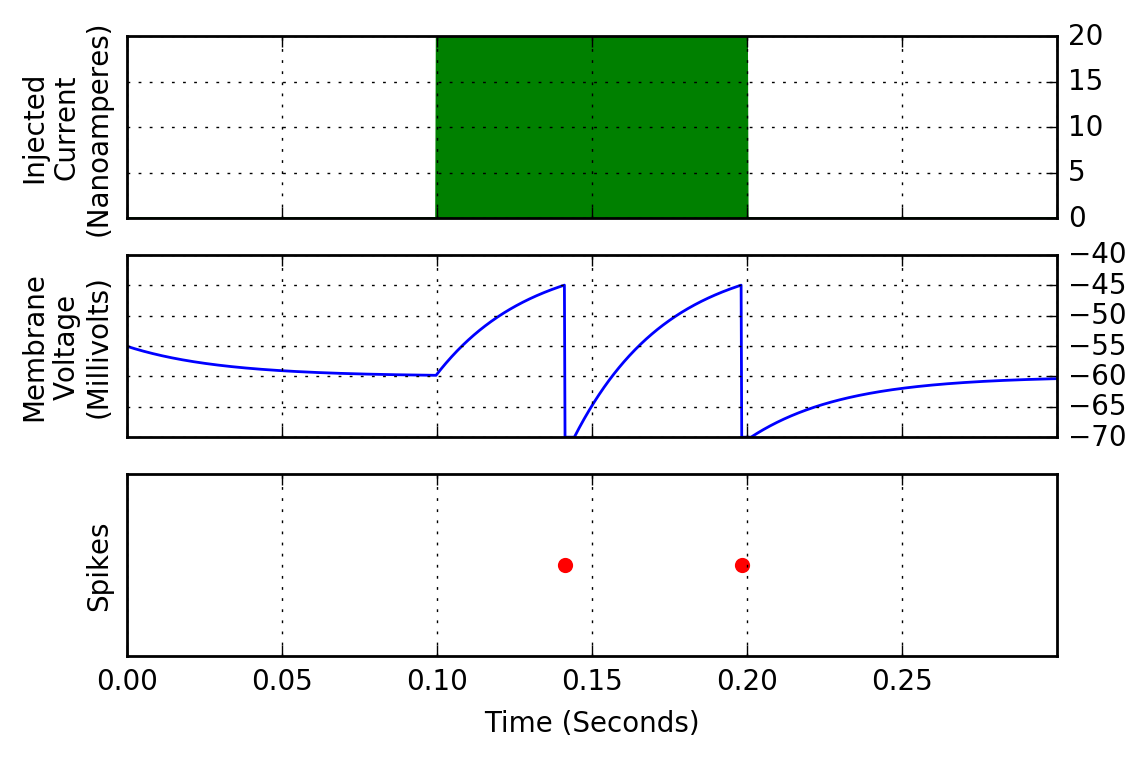

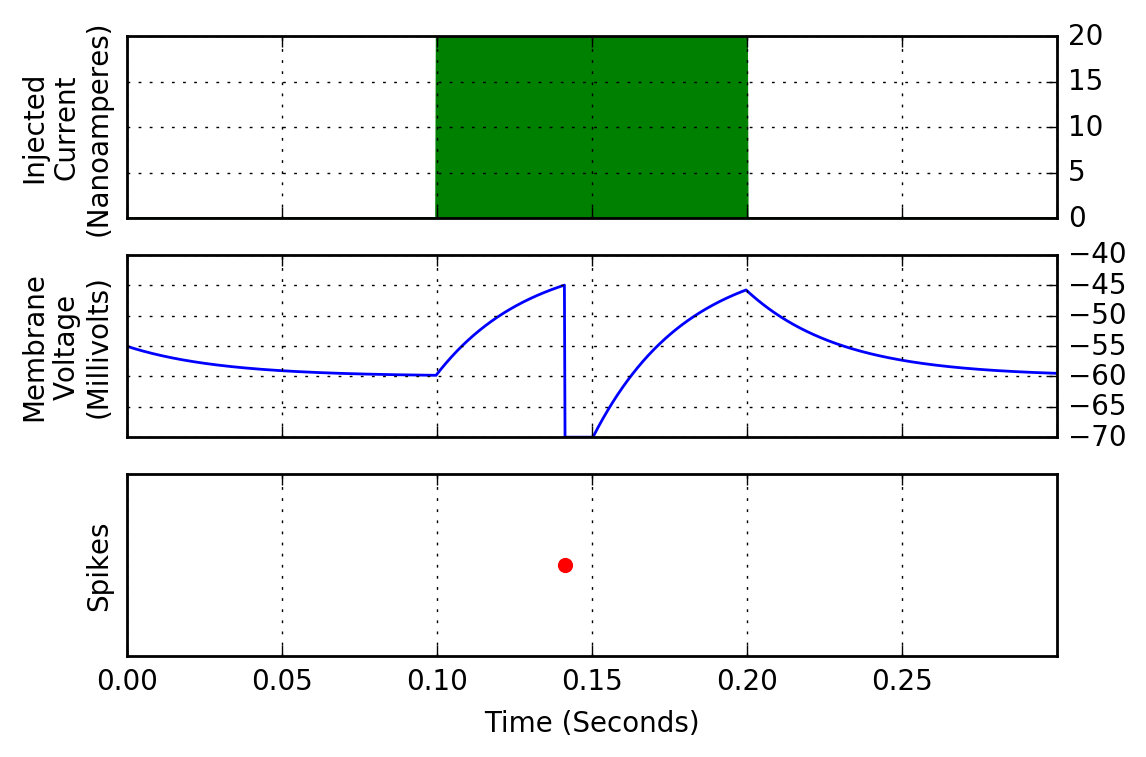

In [14]:
dt = 2e-4

Iinjects1 = 500 * [0.0]
Iinjects2 = 500 * [2e-8]
Iinjects3 = 500 * [0.0]
Iinjects = np.hstack([Iinjects1, Iinjects2, Iinjects3])

ttl_neuron = 100
seq_t = run_seq(dt, Iinjects, ttl_neuron, plot = True)

---

# Parallel Python-OpenCL Implementation

Parallel Python-OpenCL requires OpenCL driver from CPU or GPU vendor as well as PyOpenCL module for Python.

PyOpenCL version:

In [15]:
import pyopencl as cl
print("PyOpenCL %s" % cl.VERSION_TEXT)

PyOpenCL 2013.2


Set `PYOPENCL_COMPILER_OUTPUT environmental` variable to `1` in order to see OpenCL compilation outupt.

In [16]:
import os
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'

The list of all OpenCL devices found in this machine.

In [17]:
devices = []
device_names = []
for platform_id, platform in enumerate(cl.get_platforms()):
    print("Platform[%d] Vendor    : %s" % (platform_id, platform.get_info(cl.platform_info.VENDOR)))
    print("Platform[%d] Name      : %s" % (platform_id, platform.get_info(cl.platform_info.NAME)))
    print("Platform[%d] Version   : %s" % (platform_id, platform.get_info(cl.platform_info.VERSION)))
    print("Platform[%d] Device(s) :" % platform_id)
    for device_id, device in enumerate(platform.get_devices(device_type = cl.device_type.ALL)):
        devices.append(device)
        print(" - Device[%d]          : %s - %s" % (device_id, \
                                                    device.get_info(cl.device_info.VENDOR), \
                                                    device.get_info(cl.device_info.NAME)))
        device_names.append(device.get_info(cl.device_info.NAME))

Platform[0] Vendor    : Apple
Platform[0] Name      : Apple
Platform[0] Version   : OpenCL 1.2 (Oct 14 2016 20:24:13)
Platform[0] Device(s) :
 - Device[0]          : Intel - Intel(R) Core(TM) i7-3615QM CPU @ 2.30GHz
 - Device[1]          : Intel - HD Graphics 4000
 - Device[2]          : NVIDIA - GeForce GT 650M


OpenCL code (kernel) is written in C consists of `nextState` functions for:

- Python loop and iterative result (`nextState_plir`)
- Python loop and collective result (`nextState_plcr`)
- OpenCL loop and collective result (`nextState_clcr`)
- Python loop and collective result with parameter arrays (`nextState_plcr_pa`)
- OpenCL loop and collective result with parameter arrays (`nextState_clcr_pa`)
- OpenCL loop and collective result with parameter arrays that runs on one workgroup only (`nextState_clcrwg_pa`)

In [18]:
%%writefile LifNeuron.cl
// Copyright (C) 2014 by Eka A. Kurniawan
// eka.a.kurniawan(ta)gmail(tod)com
//
// This program is free software; you can redistribute it and/or modify
// it under the terms of the GNU General Public License as published by
// the Free Software Foundation; version 2 of the License.
//
// This program is distributed in the hope that it will be useful,
// but WITHOUT ANY WARRANTY; without even the implied warranty of
// MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
// GNU General Public License for more details.
//
// You should have received a copy of the GNU General Public License
// along with this program; if not, write to the
// Free Software Foundation, Inc.,
// 59 Temple Place - Suite 330, Boston, MA  02111-1307, USA.

// LifNeuron
#define LN_LEN                  13
#define LN_RM_IDX               0
#define LN_V_RESTING_IDX        1
#define LN_V_THRESH_IDX         2
#define LN_V_RESET_IDX          3
#define LN_V_INIT_IDX           4
#define LN_VM_IDX               5
#define LN_T_REFRACT_IDX        6
#define LN_SUMMATION_POINT_IDX  7
#define LN_I_INJECT_IDX         8
#define LN_C1_IDX               9
#define LN_C2_IDX               10
#define LN_N_STEPS_IN_REFR_IDX  11
#define LN_HAS_FIRED_IDX        12


__kernel void nextState_plir(const float dt,
                             const int step,
                             __global const float *Iinjects,
                             __global float *lifNeurons,
                             __global float *Vms,
                             __global int *spikes)
{
    long gid = get_global_id(0);
    long ln_idx = gid * LN_LEN;
    
    lifNeurons[ln_idx + LN_I_INJECT_IDX] = Iinjects[step];
    
    if (lifNeurons[ln_idx + LN_N_STEPS_IN_REFR_IDX] > 0) {
        lifNeurons[ln_idx + LN_N_STEPS_IN_REFR_IDX] -= 1;
        lifNeurons[ln_idx + LN_HAS_FIRED_IDX] = 0;
    } else if (lifNeurons[ln_idx + LN_VM_IDX] >= lifNeurons[ln_idx + LN_V_THRESH_IDX]) {
        lifNeurons[ln_idx + LN_HAS_FIRED_IDX] = 1;
        lifNeurons[ln_idx + LN_N_STEPS_IN_REFR_IDX] =
            (float)ceil(lifNeurons[ln_idx + LN_T_REFRACT_IDX] / dt);
        lifNeurons[ln_idx + LN_VM_IDX] = lifNeurons[ln_idx + LN_V_RESET_IDX];
    } else {
        lifNeurons[ln_idx + LN_HAS_FIRED_IDX] = 0;
        lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX] =
            lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX] +
            lifNeurons[ln_idx + LN_I_INJECT_IDX] +
            (lifNeurons[ln_idx + LN_V_RESTING_IDX] / lifNeurons[ln_idx + LN_RM_IDX]);
        lifNeurons[ln_idx + LN_VM_IDX] =
            (lifNeurons[ln_idx + LN_C1_IDX] * lifNeurons[ln_idx + LN_VM_IDX]) +
            (lifNeurons[ln_idx + LN_C2_IDX] * lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX]);
    }
        
    lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX] = 0;
        
    Vms[gid] = lifNeurons[ln_idx + LN_VM_IDX];
    if (lifNeurons[ln_idx + LN_HAS_FIRED_IDX]) {
        spikes[gid] = 1;
    } else {
        spikes[gid] = 0;
    }
}

__kernel void nextState_plcr(const float dt,
                             const int step,
                             const int input_len,
                             __global const float *Iinjects,
                             __global float *lifNeurons,
                             __global float *Vms,
                             __global int *spikes)
{
    long gid = get_global_id(0);
    // Start index of neuron
    long ln_idx = gid * LN_LEN;
    // Index to store Vm and spike
    long out_idx = gid * input_len;
    
    lifNeurons[ln_idx + LN_I_INJECT_IDX] = Iinjects[step];
    
    if (lifNeurons[ln_idx + LN_N_STEPS_IN_REFR_IDX] > 0) {
        lifNeurons[ln_idx + LN_N_STEPS_IN_REFR_IDX] -= 1;
        lifNeurons[ln_idx + LN_HAS_FIRED_IDX] = 0;
    } else if (lifNeurons[ln_idx + LN_VM_IDX] >= lifNeurons[ln_idx + LN_V_THRESH_IDX]) {
        lifNeurons[ln_idx + LN_HAS_FIRED_IDX] = 1;
        lifNeurons[ln_idx + LN_N_STEPS_IN_REFR_IDX] =
            (float)ceil(lifNeurons[ln_idx + LN_T_REFRACT_IDX] / dt);
        lifNeurons[ln_idx + LN_VM_IDX] = lifNeurons[ln_idx + LN_V_RESET_IDX];
    } else {
        lifNeurons[ln_idx + LN_HAS_FIRED_IDX] = 0;
        lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX] =
            lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX] +
            lifNeurons[ln_idx + LN_I_INJECT_IDX] +
            (lifNeurons[ln_idx + LN_V_RESTING_IDX] / lifNeurons[ln_idx + LN_RM_IDX]);
        lifNeurons[ln_idx + LN_VM_IDX] =
            (lifNeurons[ln_idx + LN_C1_IDX] * lifNeurons[ln_idx + LN_VM_IDX]) +
            (lifNeurons[ln_idx + LN_C2_IDX] * lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX]);
    }
    
    lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX] = 0;
    
    Vms[out_idx + step] = lifNeurons[ln_idx + LN_VM_IDX];
    if (lifNeurons[ln_idx + LN_HAS_FIRED_IDX]) {
        spikes[out_idx + step] = 1;
    } else {
        spikes[out_idx + step] = 0;
    }
}

__kernel void nextState_clcr(const float dt,
                             const int input_len,
                             __global const float *Iinjects,
                             __global float *lifNeurons,
                             __global float *Vms,
                             __global int *spikes)
{
    long gid = get_global_id(0);
    // Start index of neuron
    long ln_idx = gid * LN_LEN;
    // Index to store Vm and spike
    long out_idx = gid * input_len;
    
    for (int step = 0; step < input_len; step++) {
        lifNeurons[ln_idx + LN_I_INJECT_IDX] = Iinjects[step];
        
        if (lifNeurons[ln_idx + LN_N_STEPS_IN_REFR_IDX] > 0) {
            lifNeurons[ln_idx + LN_N_STEPS_IN_REFR_IDX] -= 1;
            lifNeurons[ln_idx + LN_HAS_FIRED_IDX] = 0;
        } else if (lifNeurons[ln_idx + LN_VM_IDX] >= lifNeurons[ln_idx + LN_V_THRESH_IDX]) {
            lifNeurons[ln_idx + LN_HAS_FIRED_IDX] = 1;
            lifNeurons[ln_idx + LN_N_STEPS_IN_REFR_IDX] =
                (float)ceil(lifNeurons[ln_idx + LN_T_REFRACT_IDX] / dt);
            lifNeurons[ln_idx + LN_VM_IDX] = lifNeurons[ln_idx + LN_V_RESET_IDX];
        } else {
            lifNeurons[ln_idx + LN_HAS_FIRED_IDX] = 0;
            lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX] =
                lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX] +
                lifNeurons[ln_idx + LN_I_INJECT_IDX] +
                (lifNeurons[ln_idx + LN_V_RESTING_IDX] / lifNeurons[ln_idx + LN_RM_IDX]);
            lifNeurons[ln_idx + LN_VM_IDX] =
                (lifNeurons[ln_idx + LN_C1_IDX] * lifNeurons[ln_idx + LN_VM_IDX]) +
                (lifNeurons[ln_idx + LN_C2_IDX] * lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX]);
        }
        
        lifNeurons[ln_idx + LN_SUMMATION_POINT_IDX] = 0;
        
        Vms[out_idx + step] = lifNeurons[ln_idx + LN_VM_IDX];
        if (lifNeurons[ln_idx + LN_HAS_FIRED_IDX]) {
            spikes[out_idx + step] = 1;
        } else {
            spikes[out_idx + step] = 0;
        }
        barrier(CLK_LOCAL_MEM_FENCE | CLK_GLOBAL_MEM_FENCE);
    }
}

__kernel void nextState_plcr_pa(const float dt,
                                const int step,
                                const int input_len,
                                __global const float *Iinjects,
                                __global const float *lif_Rm,
                                __global const float *lif_Vresting,
                                __global const float *lif_Vthresh,
                                __global const float *lif_Vreset,
                                __global const float *lif_Vinit,
                                __global float *lif_Vm,
                                __global const float *lif_Trefract,
                                __global float *lif_summationPoint,
                                __global float *lif_Iinject,
                                __global const float *lif_C1,
                                __global const float *lif_C2,
                                __global int *lif_nStepsInRefr,
                                __global int *lif_hasFired,
                                __global float *Vms,
                                __global int *spikes)
{
    long gid = get_global_id(0);
    // Index to store Vm and spike
    long out_idx = gid * input_len;
    
    float Iinject = Iinjects[step];
    lif_Iinject[gid] = Iinject;
    int hasFired;
    float Vm = lif_Vm[gid];
    
    if (lif_nStepsInRefr[gid] > 0) {
        lif_nStepsInRefr[gid] -= 1;
        hasFired = 0;
    } else if (Vm >= lif_Vthresh[gid]) {
        hasFired = 1;
        lif_nStepsInRefr[gid] = ceil(lif_Trefract[gid] / dt);
        Vm = lif_Vreset[gid];
    } else {
        hasFired = 0;
        float summationPoint = lif_summationPoint[gid] + Iinject +
                               (lif_Vresting[gid] / lif_Rm[gid]);
        Vm = (lif_C1[gid] * Vm) + (lif_C2[gid] * summationPoint);
    }
    lif_hasFired[gid] = hasFired;
    lif_summationPoint[gid] = 0;
    
    lif_Vm[gid] = Vm;
    Vms[out_idx + step] = Vm;
    if (hasFired) {
        spikes[out_idx + step] = 1;
    } else {
        spikes[out_idx + step] = 0;
    }
}

__kernel void nextState_clcr_pa(const float dt,
                                const int input_len,
                                __global const float *Iinjects,
                                __global const float *lif_Rm,
                                __global const float *lif_Vresting,
                                __global const float *lif_Vthresh,
                                __global const float *lif_Vreset,
                                __global const float *lif_Vinit,
                                __global float *lif_Vm,
                                __global const float *lif_Trefract,
                                __global float *lif_summationPoint,
                                __global float *lif_Iinject,
                                __global const float *lif_C1,
                                __global const float *lif_C2,
                                __global int *lif_nStepsInRefr,
                                __global int *lif_hasFired,
                                __global float *Vms,
                                __global int *spikes)
{
    long gid = get_global_id(0);
    // Index to store Vm and spike
    long out_idx = gid * input_len;
    
    int nStepsInRefr = lif_nStepsInRefr[gid];
    int hasFired;
    float Vm = lif_Vm[gid];
    float summationPoint = lif_summationPoint[gid];
    
    for (int step = 0; step < input_len; step++) {
        if (nStepsInRefr > 0) {
            nStepsInRefr -= 1;
            hasFired = 0;
        } else if (Vm >= lif_Vthresh[gid]) {
            hasFired = 1;
            spikes[out_idx + step] = 1;
            nStepsInRefr = ceil(lif_Trefract[gid] / dt);
            Vm = lif_Vreset[gid];
        } else {
            hasFired = 0;
            summationPoint = summationPoint + Iinjects[step] +
                             (lif_Vresting[gid] / lif_Rm[gid]);
            Vm = (lif_C1[gid] * Vm) + (lif_C2[gid] * summationPoint);
        }
        summationPoint = 0;
        Vms[out_idx + step] = Vm;
        barrier(CLK_LOCAL_MEM_FENCE | CLK_GLOBAL_MEM_FENCE);
    }
}

#define BLOCK_START(pid, np, n) ((pid * n) / np)
#define BLOCK_END(pid, np, n) ((((pid + 1) * n) / np) - 1)

__kernel void nextState_clcrwg_pa(const float dt,
                                  const int input_len,
                                  __global const float *Iinjects,
                                  __global const float *lif_Rm,
                                  __global const float *lif_Vresting,
                                  __global const float *lif_Vthresh,
                                  __global const float *lif_Vreset,
                                  __global const float *lif_Vinit,
                                  __global float *lif_Vm,
                                  __global const float *lif_Trefract,
                                  __global float *lif_summationPoint,
                                  __global float *lif_Iinject,
                                  __global const float *lif_C1,
                                  __global const float *lif_C2,
                                  __global int *lif_nStepsInRefr,
                                  __global int *lif_hasFired,
                                  __global float *Vms,
                                  __global int *spikes)
{
    long grid = get_group_id(0);
    if (grid != 0) return;
    
    long gsz = get_global_size(0);
    long lsz = get_local_size(0);
    long lid = get_local_id(0);
    long start_idx = BLOCK_START(lid, lsz, gsz);
    long end_idx = BLOCK_END(lid, lsz, gsz);
    
    int input_len_lm = input_len;
    for (int step = 0; step < input_len_lm; step++) {
        for (long idx = start_idx; idx <= end_idx; idx++) {
            // Index to store Vm and spike
            long out_idx = idx * input_len_lm;
            
            int nStepsInRefr = lif_nStepsInRefr[idx];
            int hasFired;
            float Vm = lif_Vm[idx];
            float summationPoint = lif_summationPoint[idx];
            
            if (nStepsInRefr > 0) {
                nStepsInRefr -= 1;
                hasFired = 0;
            } else if (Vm >= lif_Vthresh[idx]) {
                hasFired = 1;
                spikes[out_idx + step] = 1;
                nStepsInRefr = ceil(lif_Trefract[idx] / dt);
                Vm = lif_Vreset[idx];
            } else {
                hasFired = 0;
                summationPoint = summationPoint + Iinjects[step] +
                                 (lif_Vresting[idx] / lif_Rm[idx]);
                Vm = (lif_C1[idx] * Vm) + (lif_C2[idx] * summationPoint);
            }
            Vms[out_idx + step] = Vm;
            lif_Vm[idx] = Vm;
            lif_nStepsInRefr[idx] = nStepsInRefr;
            lif_hasFired[idx] = hasFired;
            lif_summationPoint[idx] = 0;
        }
        barrier(CLK_LOCAL_MEM_FENCE | CLK_GLOBAL_MEM_FENCE);
    }
}



Overwriting LifNeuron.cl


Functions to setup OpenCL devices and create OpenCL program.

In [19]:
def cl_setup(platform_id, device_id):
    platform = cl.get_platforms()[platform_id]
    device = platform.get_devices()[device_id]
    context = cl.Context(devices = [device])
    queue = cl.CommandQueue(context, device = device)
    return platform, device, context, queue

def cl_set_context(device):
    return cl.Context(devices = [device])

def cl_set_queue(context, device):
    return cl.CommandQueue(context, device = device)

def cl_create_program(context, device, filename):
    fh = open(filename, 'r')
    code = fh.read()
    program = cl.Program(context, code)
    program.build(devices = [device])
    return program

## Flow Optimization

### Parallel Implementation of Python Loop and Iterative Result (`par_plir` Function)

Parallel function done in Python-OpenCL does time step iteration in Python and collects spike result every iteration.

<center><br>
<img src="https://raw.github.com/ekaakurniawan/3nb/master/Neuron%20Models/LifNeuron/Images/Parallel%20Flow%20-%2001%20plir.png" width=400 />
<br>
<i>Parallel Implementation of Python Loop and Iterative Result</i>
</center><br>

In [20]:
def run_par_plir(device_id, dt, Iinjects, ttl_neuron, plot = False):
    # Result collection time is N/A
    rct = np.nan
    
    # Setup OpenCL
    cl_device = devices[device_id]
    cl_context = cl_set_context(cl_device)
    cl_queue = cl_set_queue(cl_context, cl_device)
    
    # Create neurons
    input_len = len(Iinjects)
    trefracts = np.linspace(3e-3, 9e-3, ttl_neuron)
    lifNeurons = []
    for i in range(ttl_neuron):
        lifNeurons.append(LifNeuron(Vinit = -0.055, Vreset = -0.07, Trefract = trefracts[i]))
    
    # Create OpenCL buffer
    tic = time.time()
    mf = cl.mem_flags
    # Iinjects
    Iinjects_np = np.array(Iinjects, dtype = np.float32)
    Iinjects_buf = cl.Buffer(cl_context, \
                             mf.READ_ONLY | mf.COPY_HOST_PTR, \
                             hostbuf = Iinjects_np)
    # LifNeurons
    lifNeurons_arr = []
    for lifNeuron in lifNeurons:
        lifNeurons_arr.append(lifNeuron.Rm)
        lifNeurons_arr.append(lifNeuron.Vresting)
        lifNeurons_arr.append(lifNeuron.Vthresh)
        lifNeurons_arr.append(lifNeuron.Vreset)
        lifNeurons_arr.append(lifNeuron.Vinit)
        lifNeurons_arr.append(lifNeuron.Vm)
        lifNeurons_arr.append(lifNeuron.Trefract)
        lifNeurons_arr.append(lifNeuron.summationPoint)
        lifNeurons_arr.append(lifNeuron.Iinject)
        lifNeurons_arr.append(lifNeuron.C1)
        lifNeurons_arr.append(lifNeuron.C2)
        lifNeurons_arr.append(lifNeuron.nStepsInRefr)
        lifNeurons_arr.append(lifNeuron.hasFired)
    lifNeurons_np = np.array(lifNeurons_arr, dtype = np.float32)
    lifNeurons_buf = cl.Buffer(cl_context, \
                               mf.READ_WRITE | mf.COPY_HOST_PTR, \
                               hostbuf = lifNeurons_np)
    # Vms
    Vms_np = np.zeros(ttl_neuron, dtype = np.float32)
    Vms_buf = cl.Buffer(cl_context, \
                        mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                        hostbuf = Vms_np)
    # Spikes
    spikes_np = np.zeros(ttl_neuron, dtype = np.int32)
    spikes_buf = cl.Buffer(cl_context, \
                           mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                           hostbuf = spikes_np)
    toc = time.time()
    # Buffer allocation time
    bat = toc - tic
    
    # Create OpenCL program
    cl_program = cl_create_program(cl_context, cl_device, "./LifNeuron.cl")
    
    # Run
    Vms = np.zeros((ttl_neuron, input_len))
    spikes = [[] for i in range(ttl_neuron)]
    tic = time.time()
    for step in range(input_len):
        cl_program.nextState_plir(cl_queue, \
                                  (ttl_neuron,), None, \
                                  np.float32(dt), \
                                  np.int32(step), \
                                  Iinjects_buf, \
                                  lifNeurons_buf, \
                                  Vms_buf, \
                                  spikes_buf).wait()
        cl.enqueue_copy(cl_queue, Vms_np, Vms_buf)
        cl.enqueue_copy(cl_queue, spikes_np, spikes_buf)
        
        Vms[:,step] = Vms_np
        for i in spikes_np.nonzero()[0]:
            spikes[i].append(step * dt)
    toc = time.time()
    # Run time
    rt = toc - tic
    
    if plot:
        plot_spikes(dt, Iinjects, Vms[0], spikes[0])
        plot_spikes(dt, Iinjects, Vms[-1], spikes[-1])

    # Total time
    tt = bat + rt
    # Return execution times
    return bat, rt, rct, tt

Testing code plots the first and last neurons.

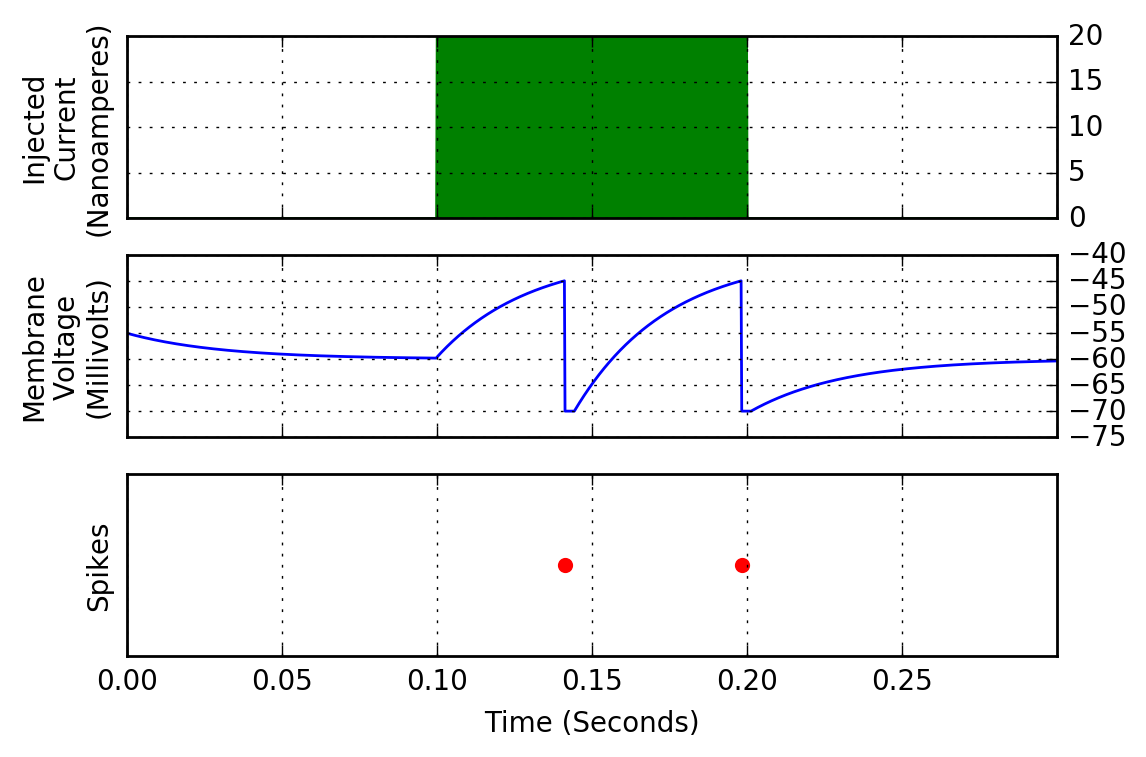

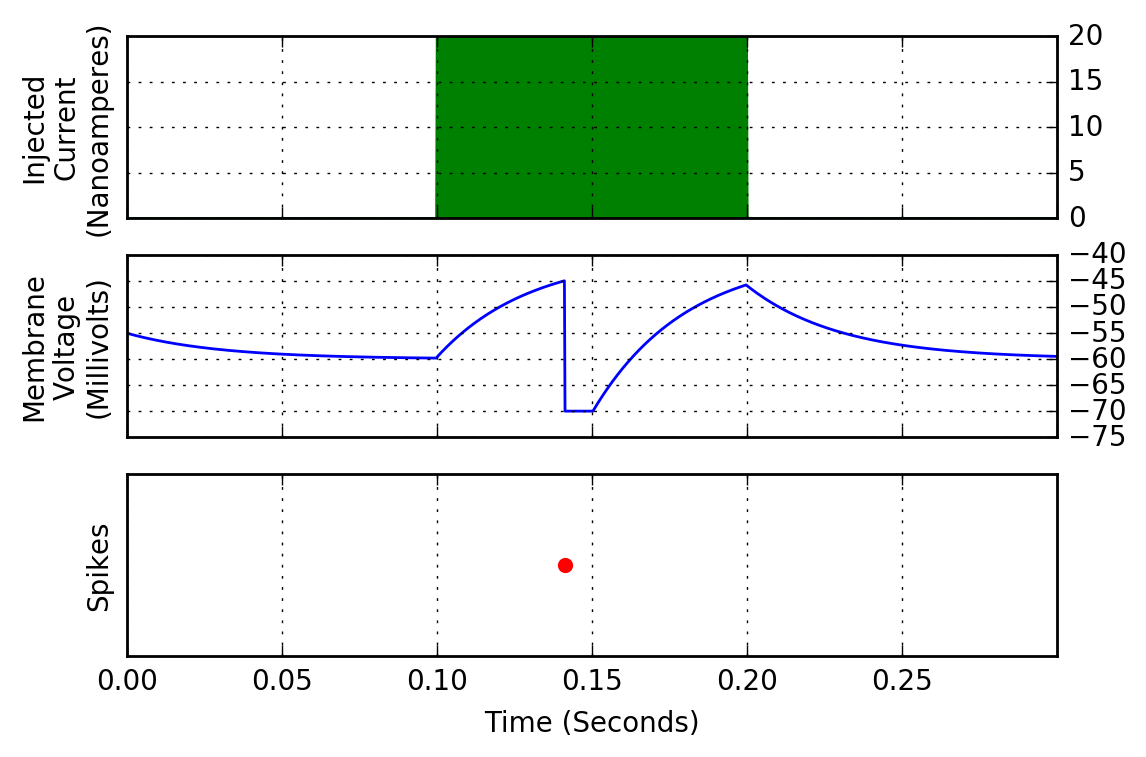

In [21]:
device_id = 1
dt = 2e-4

Iinjects1 = 500 * [0.0]
Iinjects2 = 500 * [2e-8]
Iinjects3 = 500 * [0.0]
Iinjects = np.hstack([Iinjects1, Iinjects2, Iinjects3])

ttl_neuron = 100
par_plir_t = run_par_plir(device_id, dt, Iinjects, ttl_neuron, plot = True)

### Parallel Implementation of Python Loop and Collective Result (`par_plcr` Function)

Parallel function done in Python-OpenCL does time step iteration in Python and collects all spike results together at the end of iteration.

<center><br>
<img src="https://raw.github.com/ekaakurniawan/3nb/master/Neuron%20Models/LifNeuron/Images/Parallel%20Flow%20-%2002%20plcr.png" width=400 />
<br>
<i>Parallel Implementation of Python Loop and Collective Result</i>
</center><br>

In [22]:
def run_par_plcr(device_id, dt, Iinjects, ttl_neuron, plot = False):
    # Setup OpenCL
    cl_device = devices[device_id]
    cl_context = cl_set_context(cl_device)
    cl_queue = cl_set_queue(cl_context, cl_device)
    
    # Create neurons
    input_len = len(Iinjects)
    trefracts = np.linspace(3e-3, 9e-3, ttl_neuron)
    lifNeurons = []
    for i in range(ttl_neuron):
        lifNeurons.append(LifNeuron(Vinit = -0.055, Vreset = -0.07, Trefract = trefracts[i]))
    
    # Create OpenCL buffer
    tic = time.time()
    mf = cl.mem_flags
    # Iinjects
    Iinjects_np = np.array(Iinjects, dtype = np.float32)
    Iinjects_buf = cl.Buffer(cl_context, \
                             mf.READ_ONLY | mf.COPY_HOST_PTR, \
                             hostbuf = Iinjects_np)
    # Input Length
    input_len_np = np.array([input_len], dtype = np.int32)
    input_len_buf = cl.Buffer(cl_context, \
                              mf.READ_ONLY | mf.COPY_HOST_PTR, \
                              hostbuf = input_len_np)
    # LifNeurons
    lifNeurons_arr = []
    for lifNeuron in lifNeurons:
        lifNeurons_arr.append(lifNeuron.Rm)
        lifNeurons_arr.append(lifNeuron.Vresting)
        lifNeurons_arr.append(lifNeuron.Vthresh)
        lifNeurons_arr.append(lifNeuron.Vreset)
        lifNeurons_arr.append(lifNeuron.Vinit)
        lifNeurons_arr.append(lifNeuron.Vm)
        lifNeurons_arr.append(lifNeuron.Trefract)
        lifNeurons_arr.append(lifNeuron.summationPoint)
        lifNeurons_arr.append(lifNeuron.Iinject)
        lifNeurons_arr.append(lifNeuron.C1)
        lifNeurons_arr.append(lifNeuron.C2)
        lifNeurons_arr.append(lifNeuron.nStepsInRefr)
        lifNeurons_arr.append(lifNeuron.hasFired)
    lifNeurons_np = np.array(lifNeurons_arr, dtype = np.float32)
    lifNeurons_buf = cl.Buffer(cl_context, \
                               mf.READ_WRITE | mf.COPY_HOST_PTR, \
                               hostbuf = lifNeurons_np)
    # Vms
    Vms_np = np.zeros((ttl_neuron, input_len), dtype = np.float32)
    Vms_buf = cl.Buffer(cl_context, \
                        mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                        hostbuf = Vms_np)
    # Spikes Collection
    spikes_coll_np = np.zeros((ttl_neuron, input_len), dtype = np.int32)
    spikes_coll_buf = cl.Buffer(cl_context, \
                                mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                                hostbuf = spikes_coll_np)
    toc = time.time()
    # Buffer allocation time
    bat = toc - tic
    
    # Create OpenCL program
    cl_program = cl_create_program(cl_context, cl_device, "./LifNeuron.cl")
    
    # Run
    tic = time.time()
    for step in range(input_len):
        cl_program.nextState_plcr(cl_queue, \
                                  (ttl_neuron,), None, \
                                  np.float32(dt), \
                                  np.int32(step), \
                                  np.int32(input_len), \
                                  Iinjects_buf, \
                                  lifNeurons_buf, \
                                  Vms_buf, \
                                  spikes_coll_buf).wait()
    toc = time.time()
    # Run time
    rt = toc - tic
    
    # Collect result
    tic = time.time()
    cl.enqueue_copy(cl_queue, Vms_np, Vms_buf)
    Vms = Vms_np
    
    cl.enqueue_copy(cl_queue, spikes_coll_np, spikes_coll_buf)
    spikes = [[] for i in range(ttl_neuron)]
    for n_idx, spikes_np in enumerate(spikes_coll_np):
        spikes[n_idx] = spikes_np.nonzero()[0] * dt
    toc = time.time()
    # Result collection time
    rct = toc - tic
    
    if plot:
        plot_spikes(dt, Iinjects, Vms[0], spikes[0])
        plot_spikes(dt, Iinjects, Vms[-1], spikes[-1])
    
    # Total time
    tt = bat + rt + rct
    return bat, rt, rct, tt

Testing code plots the first and last neurons.

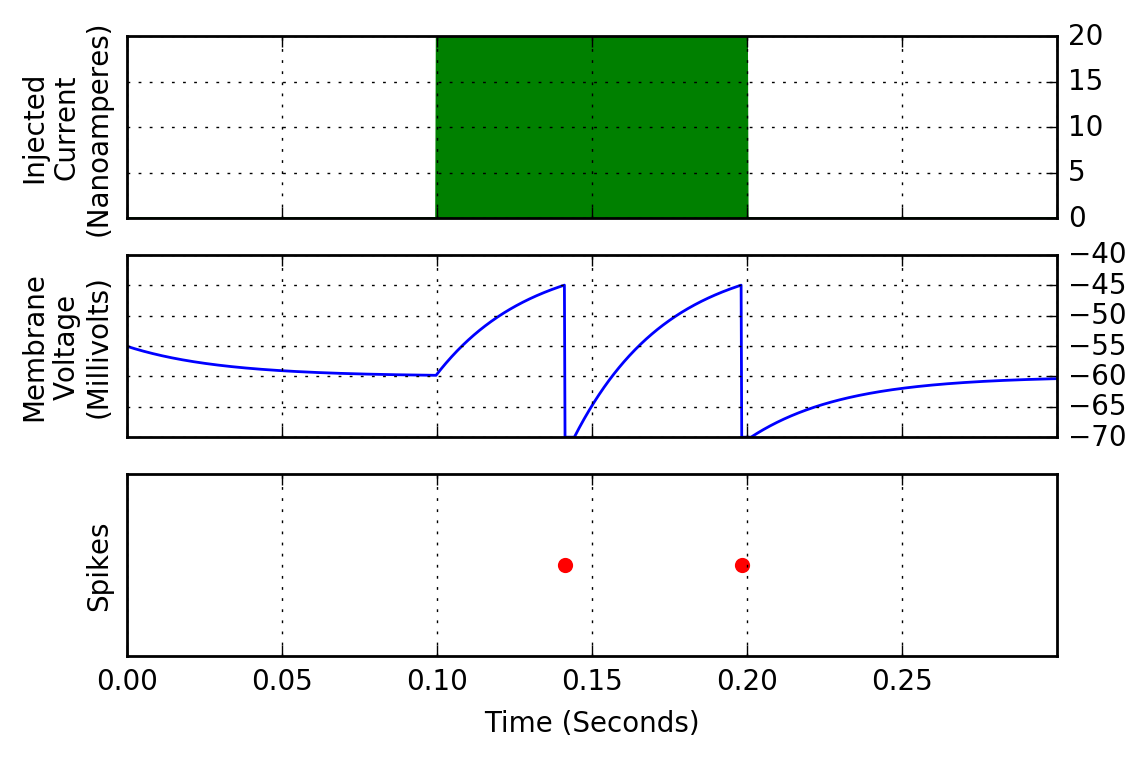

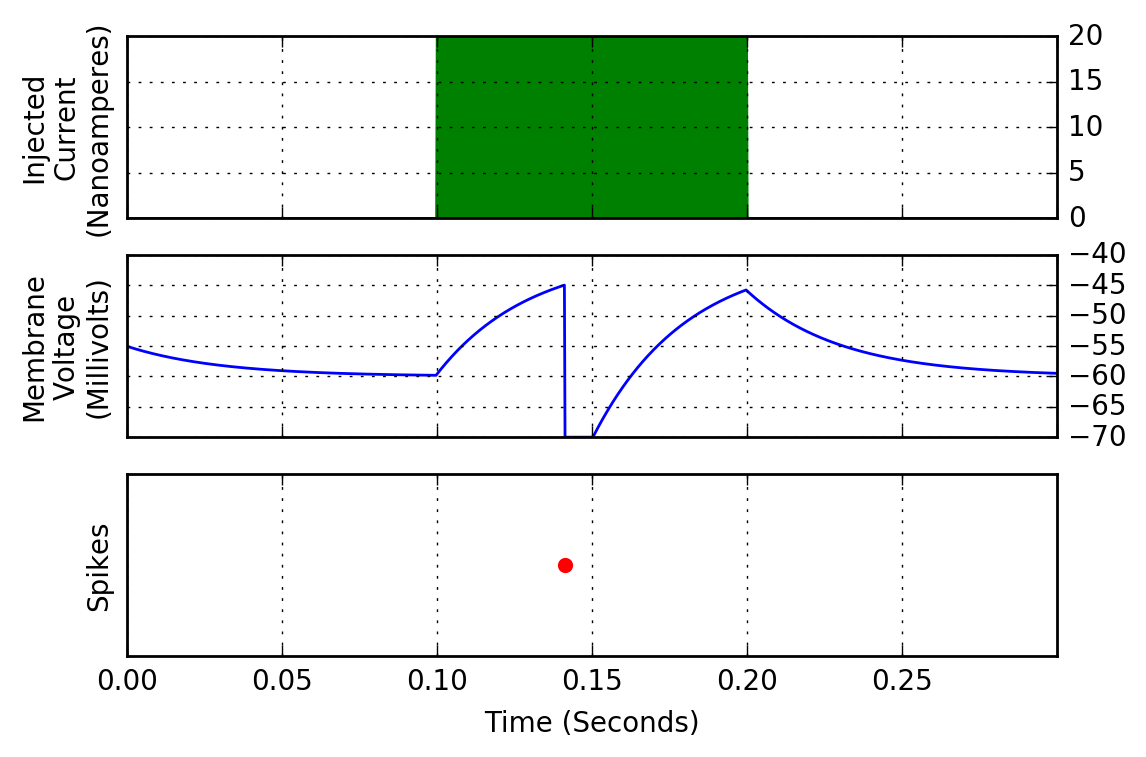

In [23]:
device_id = 1

dt = 2e-4

Iinjects1 = 500 * [0.0]
Iinjects2 = 500 * [2e-8]
Iinjects3 = 500 * [0.0]
Iinjects = np.hstack([Iinjects1, Iinjects2, Iinjects3])

ttl_neuron = 100
par_plcr_t = run_par_plcr(device_id, dt, Iinjects, ttl_neuron, plot = True)

### Parallel Implementation of OpenCL Loop and Collective Result (`par_clcr` Function)

Parallel function done in Python-OpenCL does time step iteration in OpenCL and collects all spike results together at the end of iteration.

<center><br>
<img src="https://raw.github.com/ekaakurniawan/3nb/master/Neuron%20Models/LifNeuron/Images/Parallel%20Flow%20-%2003%20clcr.png" width=400 />
<br>
<i>Parallel Implementation of OpenCL Loop and Collective Result</i>
</center><br>

In [24]:
def run_par_clcr(device_id, dt, Iinjects, ttl_neuron, plot = False):
    # Setup OpenCL
    cl_device = devices[device_id]
    cl_context = cl_set_context(cl_device)
    cl_queue = cl_set_queue(cl_context, cl_device)
    
    # Create neurons
    input_len = len(Iinjects)
    trefracts = np.linspace(3e-3, 9e-3, ttl_neuron)
    lifNeurons = []
    for i in range(ttl_neuron):
        lifNeurons.append(LifNeuron(Vinit = -0.055, Vreset = -0.07, Trefract = trefracts[i]))
    
    # Create OpenCL buffer
    tic = time.time()
    mf = cl.mem_flags
    # Iinjects
    Iinjects_np = np.array(Iinjects, dtype = np.float32)
    Iinjects_buf = cl.Buffer(cl_context, \
                             mf.READ_ONLY | mf.COPY_HOST_PTR, \
                             hostbuf = Iinjects_np)
    # LifNeurons
    lifNeurons_arr = []
    for lifNeuron in lifNeurons:
        lifNeurons_arr.append(lifNeuron.Rm)
        lifNeurons_arr.append(lifNeuron.Vresting)
        lifNeurons_arr.append(lifNeuron.Vthresh)
        lifNeurons_arr.append(lifNeuron.Vreset)
        lifNeurons_arr.append(lifNeuron.Vinit)
        lifNeurons_arr.append(lifNeuron.Vm)
        lifNeurons_arr.append(lifNeuron.Trefract)
        lifNeurons_arr.append(lifNeuron.summationPoint)
        lifNeurons_arr.append(lifNeuron.Iinject)
        lifNeurons_arr.append(lifNeuron.C1)
        lifNeurons_arr.append(lifNeuron.C2)
        lifNeurons_arr.append(lifNeuron.nStepsInRefr)
        lifNeurons_arr.append(lifNeuron.hasFired)
    lifNeurons_np = np.array(lifNeurons_arr, dtype = np.float32)
    lifNeurons_buf = cl.Buffer(cl_context, \
                               mf.READ_WRITE | mf.COPY_HOST_PTR, \
                               hostbuf = lifNeurons_np)
    # Vms
    Vms_np = np.zeros((ttl_neuron, input_len), dtype = np.float32)
    Vms_buf = cl.Buffer(cl_context, \
                        mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                        hostbuf = Vms_np)
    # Spikes Collection
    spikes_coll_np = np.zeros((ttl_neuron, input_len), dtype = np.int32)
    spikes_coll_buf = cl.Buffer(cl_context, \
                                mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                                hostbuf = spikes_coll_np)
    toc = time.time()
    # Buffer allocation time
    bat = toc - tic
    
    # Create OpenCL program
    cl_program = cl_create_program(cl_context, cl_device, "./LifNeuron.cl")
    
    # Run
    tic = time.time()
    cl_program.nextState_clcr(cl_queue, \
                              (ttl_neuron,), None, \
                              np.float32(dt), \
                              np.int32(input_len), \
                              Iinjects_buf, \
                              lifNeurons_buf, \
                              Vms_buf, \
                              spikes_coll_buf).wait()
    toc = time.time()
    # Run time
    rt = toc - tic
    
    # Collect result
    tic = time.time()
    cl.enqueue_copy(cl_queue, Vms_np, Vms_buf)
    Vms = Vms_np
    
    cl.enqueue_copy(cl_queue, spikes_coll_np, spikes_coll_buf)
    spikes = [[] for i in range(ttl_neuron)]
    for n_idx, spikes_np in enumerate(spikes_coll_np):
        spikes[n_idx] = spikes_np.nonzero()[0] * dt
    toc = time.time()
    # Result collection time
    rct = toc - tic
    
    if plot:
        plot_spikes(dt, Iinjects, Vms[0], spikes[0])
        plot_spikes(dt, Iinjects, Vms[-1], spikes[-1])
    
    # Total time
    tt = bat + rt + rct
    return bat, rt, rct, tt

Testing code plots the first and last neurons.

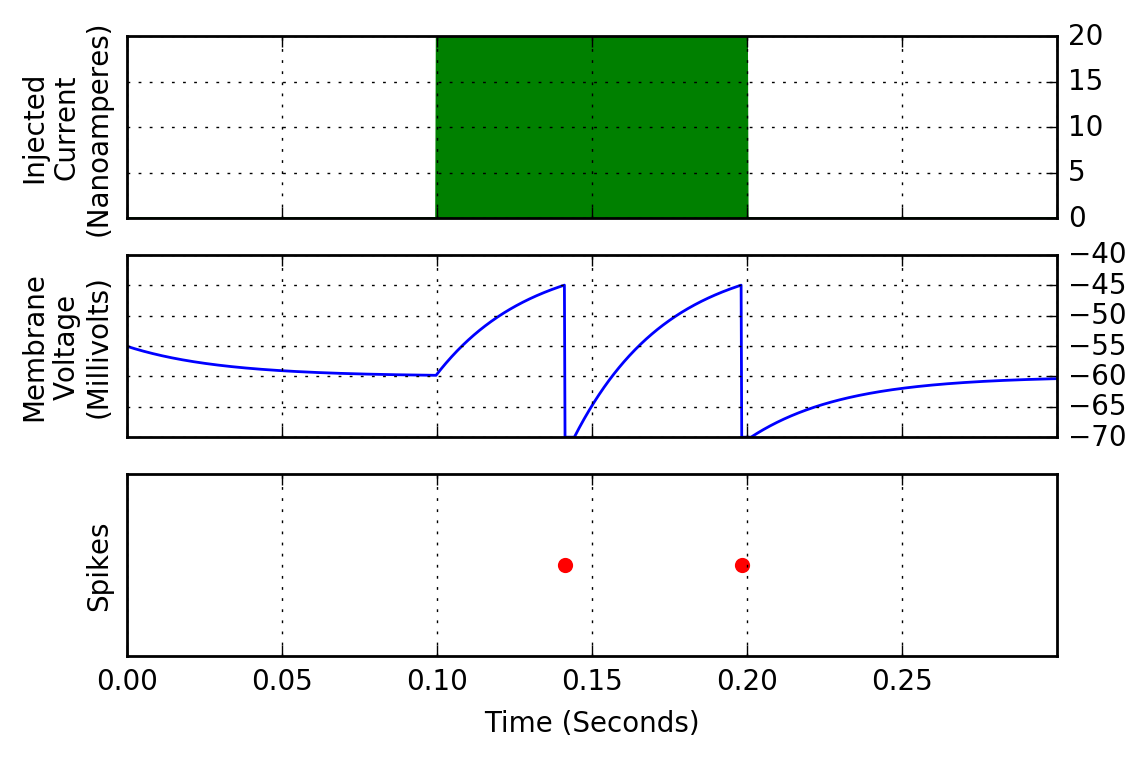

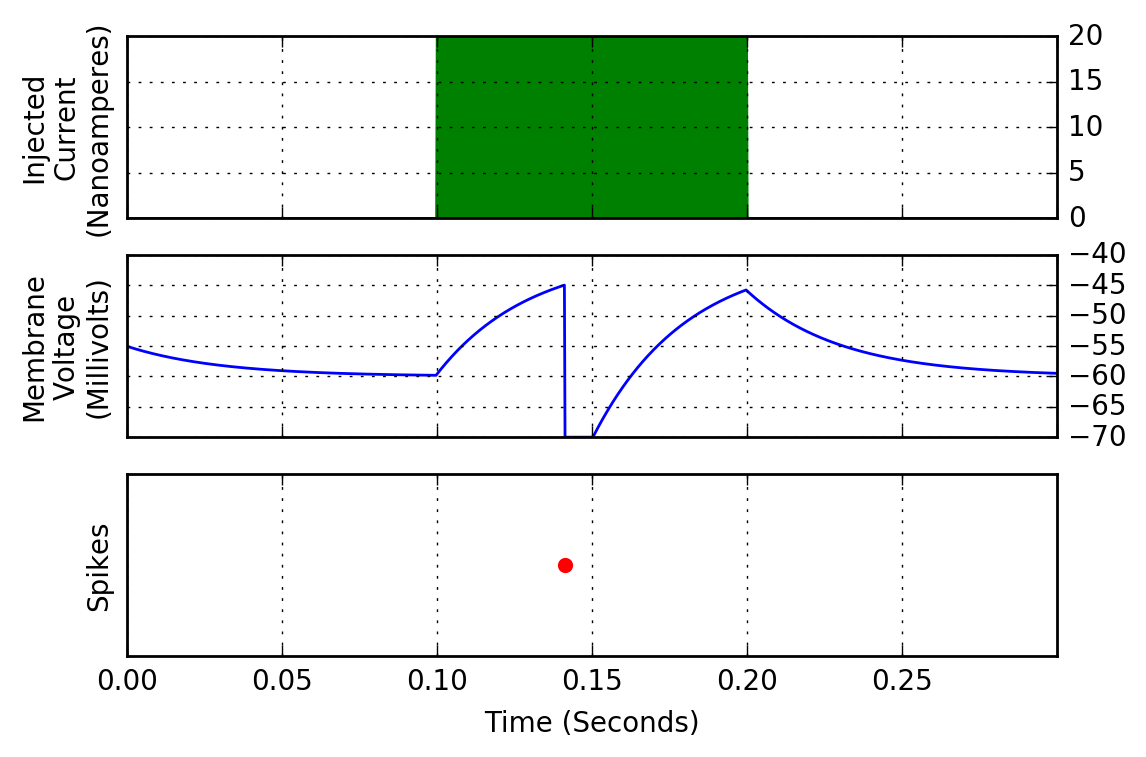

In [25]:
device_id = 1

dt = 2e-4

Iinjects1 = 500 * [0.0]
Iinjects2 = 500 * [2e-8]
Iinjects3 = 500 * [0.0]
Iinjects = np.hstack([Iinjects1, Iinjects2, Iinjects3])

ttl_neuron = 100
par_clcr_t = run_par_clcr(device_id, dt, Iinjects, ttl_neuron, plot = True)

## Data Structure Optimization

All of previous parallel implementations use Neurons Array data structure as shown below. Basically, a single array holds all parameters of entire neurons.

<center><br>
<img src="https://raw.github.com/ekaakurniawan/3nb/master/Neuron%20Models/LifNeuron/Images/Parallel%20DS%20-%2001%20Neurons%20Array.png" width=600 />
<br>
<i>Neurons Array Data Structure</i>
</center>

Another version of parallel data structure devides a single Neurons Array into multiple parameter arrays, called Parameter Arrays data structure as shown below. All functions that use this data structure have additional `pa` as part of the function name.

<center><br>
<img src="https://raw.github.com/ekaakurniawan/3nb/master/Neuron%20Models/LifNeuron/Images/Parallel%20DS%20-%2002%20Parameter%20Arrays.png" width=600 />
<br>
<i>Parameter Arrays Data Structure</i>
</center>

### Parallel Implementation of Pythpn Loop and Collective Result with Parameter Arrays (`par_plcr_pa` Function)

This function of Python loop and collective result uses optimized Parameter Arrays data structure.

In [26]:
def run_par_plcr_pa(device_id, dt, Iinjects, ttl_neuron, workitem_size = None, plot = False):
    # Setup OpenCL
    cl_device = devices[device_id]
    cl_context = cl_set_context(cl_device)
    cl_queue = cl_set_queue(cl_context, cl_device)
    
    # Create neurons
    input_len = len(Iinjects)
    trefracts = np.linspace(3e-3, 9e-3, ttl_neuron)
    lifNeurons = []
    for i in range(ttl_neuron):
        lifNeurons.append(LifNeuron(Vinit = -0.055, Vreset = -0.07, Trefract = trefracts[i]))
    
    # Create OpenCL buffer
    tic = time.time()
    mf = cl.mem_flags
    # Iinjects
    Iinjects_np = np.array(Iinjects, dtype = np.float32)
    Iinjects_buf = cl.Buffer(cl_context, \
                             mf.READ_ONLY | mf.COPY_HOST_PTR, \
                             hostbuf = Iinjects_np)
    # LifNeurons
    lif_Rm_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vresting_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vthresh_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vreset_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vinit_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vm_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Trefract_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_summationPoint_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Iinject_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_C1_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_C2_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_nStepsInRefr_np = np.zeros((ttl_neuron), dtype = np.int32)
    lif_hasFired_np = np.zeros((ttl_neuron), dtype = np.int32)
    
    for lifNeuron_idx, lifNeuron in enumerate(lifNeurons):
        lif_Rm_np[lifNeuron_idx] = lifNeuron.Rm
        lif_Vresting_np[lifNeuron_idx] = lifNeuron.Vresting
        lif_Vthresh_np[lifNeuron_idx] = lifNeuron.Vthresh
        lif_Vreset_np[lifNeuron_idx] = lifNeuron.Vreset
        lif_Vinit_np[lifNeuron_idx] = lifNeuron.Vinit
        lif_Vm_np[lifNeuron_idx] = lifNeuron.Vm
        lif_Trefract_np[lifNeuron_idx] = lifNeuron.Trefract
        lif_summationPoint_np[lifNeuron_idx] = lifNeuron.summationPoint
        lif_Iinject_np[lifNeuron_idx] = lifNeuron.Iinject
        lif_C1_np[lifNeuron_idx] = lifNeuron.C1
        lif_C2_np[lifNeuron_idx] = lifNeuron.C2
        lif_nStepsInRefr_np[lifNeuron_idx] = lifNeuron.nStepsInRefr
        lif_hasFired_np[lifNeuron_idx] = lifNeuron.hasFired
    
    lif_Rm_buf = cl.Buffer(cl_context, \
                           mf.READ_ONLY | mf.COPY_HOST_PTR, \
                           hostbuf = lif_Rm_np)
    lif_Vresting_buf = cl.Buffer(cl_context, \
                                 mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                 hostbuf = lif_Vresting_np)
    lif_Vthresh_buf = cl.Buffer(cl_context, \
                                mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                hostbuf = lif_Vthresh_np)
    lif_Vreset_buf = cl.Buffer(cl_context, \
                               mf.READ_ONLY | mf.COPY_HOST_PTR, \
                               hostbuf = lif_Vreset_np)
    lif_Vinit_buf = cl.Buffer(cl_context, \
                              mf.READ_ONLY | mf.COPY_HOST_PTR, \
                              hostbuf = lif_Vinit_np)
    lif_Vm_buf = cl.Buffer(cl_context, \
                           mf.READ_WRITE | mf.COPY_HOST_PTR, \
                           hostbuf = lif_Vm_np)
    lif_Trefract_buf = cl.Buffer(cl_context, \
                                 mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                 hostbuf = lif_Trefract_np)
    lif_summationPoint_buf = cl.Buffer(cl_context, \
                                       mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                       hostbuf = lif_summationPoint_np)
    lif_Iinject_buf = cl.Buffer(cl_context, \
                                mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                hostbuf = lif_Iinject_np)
    lif_C1_buf = cl.Buffer(cl_context, \
                           mf.READ_ONLY | mf.COPY_HOST_PTR, \
                           hostbuf = lif_C1_np)
    lif_C2_buf = cl.Buffer(cl_context, \
                           mf.READ_ONLY | mf.COPY_HOST_PTR, \
                           hostbuf = lif_C2_np)
    lif_nStepsInRefr_buf = cl.Buffer(cl_context, \
                                     mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                     hostbuf = lif_nStepsInRefr_np)
    lif_hasFired_buf = cl.Buffer(cl_context, \
                                 mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                 hostbuf = lif_hasFired_np)
    # Vms
    Vms_np = np.zeros((ttl_neuron, input_len), dtype = np.float32)
    Vms_buf = cl.Buffer(cl_context, \
                        mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                        hostbuf = Vms_np)
    # Spikes Collection
    spikes_coll_np = np.zeros((ttl_neuron, input_len), dtype = np.int32)
    spikes_coll_buf = cl.Buffer(cl_context, \
                                mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                                hostbuf = spikes_coll_np)
    toc = time.time()
    # Buffer allocation time
    bat = toc - tic
    
    # Create OpenCL program
    cl_program = cl_create_program(cl_context, cl_device, "./LifNeuron.cl")
    
    # Workitem size need to be in list format except for None
    if workitem_size != None:
        workitem_size = (workitem_size,)
    
    # Run
    tic = time.time()
    for step in range(input_len):
        cl_program.nextState_plcr_pa(cl_queue, \
                                     (ttl_neuron,), workitem_size, \
                                     np.float32(dt), \
                                     np.int32(step), \
                                     np.int32(input_len), \
                                     Iinjects_buf, \
                                     lif_Rm_buf, \
                                     lif_Vresting_buf, \
                                     lif_Vthresh_buf, \
                                     lif_Vreset_buf, \
                                     lif_Vinit_buf, \
                                     lif_Vm_buf, \
                                     lif_Trefract_buf, \
                                     lif_summationPoint_buf, \
                                     lif_Iinject_buf, \
                                     lif_C1_buf, \
                                     lif_C2_buf, \
                                     lif_nStepsInRefr_buf, \
                                     lif_hasFired_buf, \
                                     Vms_buf, \
                                     spikes_coll_buf).wait()
    toc = time.time()
    # Run time
    rt = toc - tic
    
    # Collect result
    tic = time.time()
    cl.enqueue_copy(cl_queue, Vms_np, Vms_buf)
    Vms = Vms_np
    
    cl.enqueue_copy(cl_queue, spikes_coll_np, spikes_coll_buf)
    spikes = [[] for i in range(ttl_neuron)]
    for n_idx, spikes_np in enumerate(spikes_coll_np):
        spikes[n_idx] = spikes_np.nonzero()[0] * dt
    toc = time.time()
    # Result collection time
    rct = toc - tic
    
    if plot:
        plot_spikes(dt, Iinjects, Vms[0], spikes[0])
        plot_spikes(dt, Iinjects, Vms[-1], spikes[-1])
    
    # Total time
    tt = bat + rt + rct
    return bat, rt, rct, tt

Testing code plots the first and last neurons.

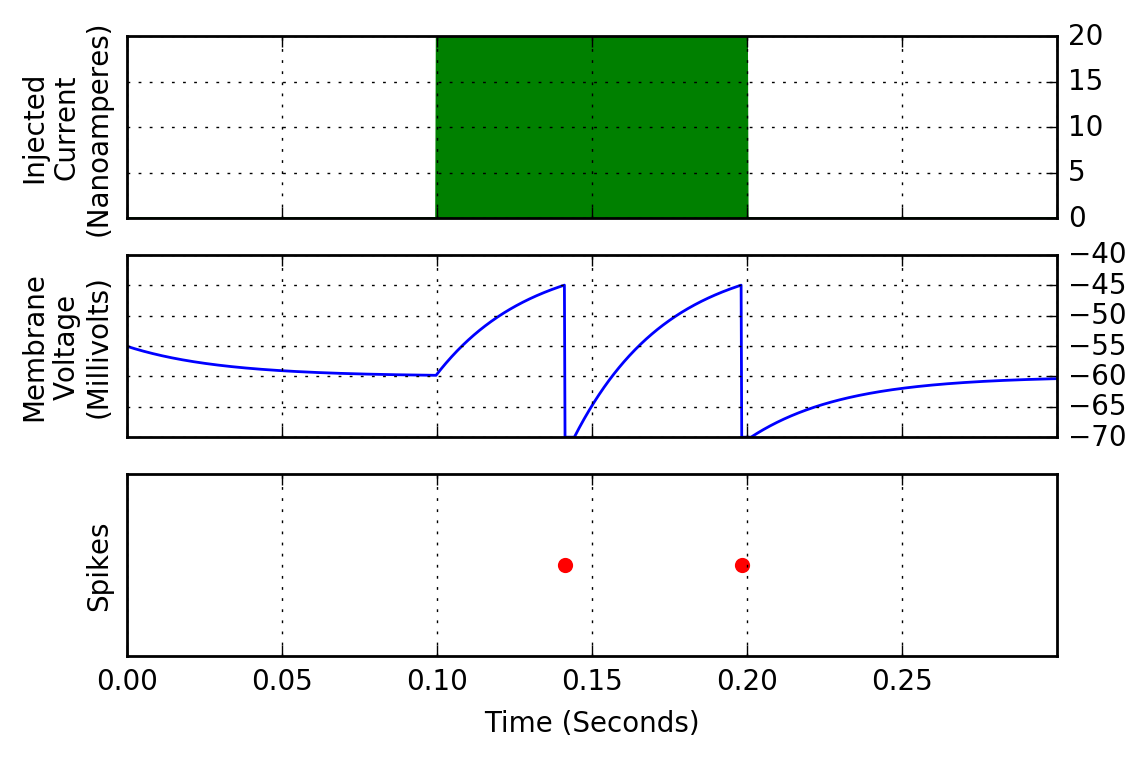

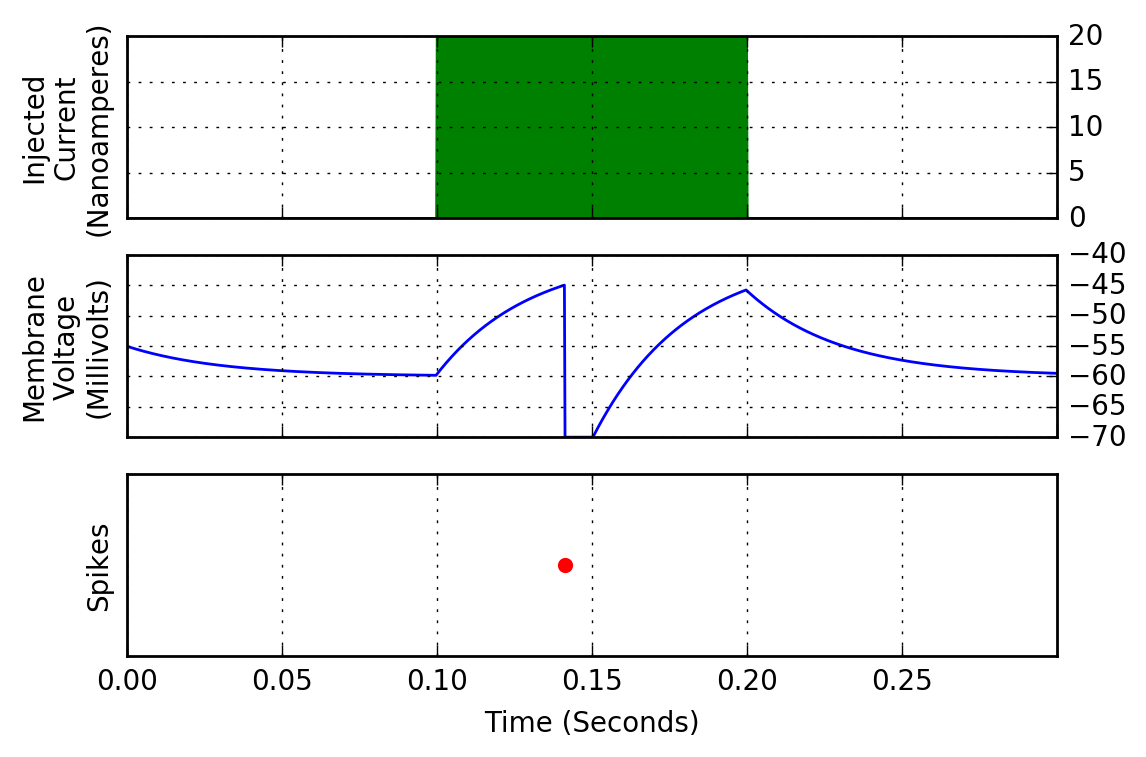

In [27]:
device_id = 1

dt = 2e-4

Iinjects1 = 500 * [0.0]
Iinjects2 = 500 * [2e-8]
Iinjects3 = 500 * [0.0]
Iinjects = np.hstack([Iinjects1, Iinjects2, Iinjects3])

ttl_neuron = 100
run_par_plcr_pa_t = run_par_plcr_pa(device_id, dt, Iinjects, ttl_neuron, plot = True)

### Parallel Implementation of OpenCL Loop and Collective Result with Parameter Arrays (`par_clcr_pa` Function)

This function of OpenCL loop and collective result uses optimized Parameter Arrays data structure.

In [28]:
def run_par_clcr_pa(device_id, dt, Iinjects, ttl_neuron, plot = False):
    # Setup OpenCL
    cl_device = devices[device_id]
    cl_context = cl_set_context(cl_device)
    cl_queue = cl_set_queue(cl_context, cl_device)
    
    # Create neurons
    input_len = len(Iinjects)
    trefracts = np.linspace(3e-3, 9e-3, ttl_neuron)
    lifNeurons = []
    for i in range(ttl_neuron):
        lifNeurons.append(LifNeuron(Vinit = -0.055, Vreset = -0.07, Trefract = trefracts[i]))
    
    # Create OpenCL buffer
    tic = time.time()
    mf = cl.mem_flags
    # Iinjects
    Iinjects_np = np.array(Iinjects, dtype = np.float32)
    Iinjects_buf = cl.Buffer(cl_context, \
                             mf.READ_ONLY | mf.COPY_HOST_PTR, \
                             hostbuf = Iinjects_np)
    # LifNeurons
    lif_Rm_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vresting_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vthresh_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vreset_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vinit_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vm_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Trefract_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_summationPoint_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Iinject_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_C1_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_C2_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_nStepsInRefr_np = np.zeros((ttl_neuron), dtype = np.int32)
    lif_hasFired_np = np.zeros((ttl_neuron), dtype = np.int32)
    
    for lifNeuron_idx, lifNeuron in enumerate(lifNeurons):
        lif_Rm_np[lifNeuron_idx] = lifNeuron.Rm
        lif_Vresting_np[lifNeuron_idx] = lifNeuron.Vresting
        lif_Vthresh_np[lifNeuron_idx] = lifNeuron.Vthresh
        lif_Vreset_np[lifNeuron_idx] = lifNeuron.Vreset
        lif_Vinit_np[lifNeuron_idx] = lifNeuron.Vinit
        lif_Vm_np[lifNeuron_idx] = lifNeuron.Vm
        lif_Trefract_np[lifNeuron_idx] = lifNeuron.Trefract
        lif_summationPoint_np[lifNeuron_idx] = lifNeuron.summationPoint
        lif_Iinject_np[lifNeuron_idx] = lifNeuron.Iinject
        lif_C1_np[lifNeuron_idx] = lifNeuron.C1
        lif_C2_np[lifNeuron_idx] = lifNeuron.C2
        lif_nStepsInRefr_np[lifNeuron_idx] = lifNeuron.nStepsInRefr
        lif_hasFired_np[lifNeuron_idx] = lifNeuron.hasFired
    
    lif_Rm_buf = cl.Buffer(cl_context, \
                           mf.READ_ONLY | mf.COPY_HOST_PTR, \
                           hostbuf = lif_Rm_np)
    lif_Vresting_buf = cl.Buffer(cl_context, \
                                 mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                 hostbuf = lif_Vresting_np)
    lif_Vthresh_buf = cl.Buffer(cl_context, \
                                mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                hostbuf = lif_Vthresh_np)
    lif_Vreset_buf = cl.Buffer(cl_context, \
                               mf.READ_ONLY | mf.COPY_HOST_PTR, \
                               hostbuf = lif_Vreset_np)
    lif_Vinit_buf = cl.Buffer(cl_context, \
                              mf.READ_ONLY | mf.COPY_HOST_PTR, \
                              hostbuf = lif_Vinit_np)
    lif_Vm_buf = cl.Buffer(cl_context, \
                           mf.READ_WRITE | mf.COPY_HOST_PTR, \
                           hostbuf = lif_Vm_np)
    lif_Trefract_buf = cl.Buffer(cl_context, \
                                 mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                 hostbuf = lif_Trefract_np)
    lif_summationPoint_buf = cl.Buffer(cl_context, \
                                       mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                       hostbuf = lif_summationPoint_np)
    lif_Iinject_buf = cl.Buffer(cl_context, \
                                mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                hostbuf = lif_Iinject_np)
    lif_C1_buf = cl.Buffer(cl_context, \
                           mf.READ_ONLY | mf.COPY_HOST_PTR, \
                           hostbuf = lif_C1_np)
    lif_C2_buf = cl.Buffer(cl_context, \
                           mf.READ_ONLY | mf.COPY_HOST_PTR, \
                           hostbuf = lif_C2_np)
    lif_nStepsInRefr_buf = cl.Buffer(cl_context, \
                                     mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                     hostbuf = lif_nStepsInRefr_np)
    lif_hasFired_buf = cl.Buffer(cl_context, \
                                 mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                 hostbuf = lif_hasFired_np)
    # Vms
    Vms_np = np.zeros((ttl_neuron, input_len), dtype = np.float32)
    Vms_buf = cl.Buffer(cl_context, \
                        mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                        hostbuf = Vms_np)
    # Spikes Collection
    spikes_coll_np = np.zeros((ttl_neuron, input_len), dtype = np.int32)
    spikes_coll_buf = cl.Buffer(cl_context, \
                                mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                                hostbuf = spikes_coll_np)
    toc = time.time()
    # Buffer allocation time
    bat = toc - tic
    
    # Create OpenCL program
    cl_program = cl_create_program(cl_context, cl_device, "./LifNeuron.cl")
    
    # Run
    tic = time.time()
    cl_program.nextState_clcr_pa(cl_queue, \
                                 (ttl_neuron,), None, \
                                 np.float32(dt), \
                                 np.int32(input_len), \
                                 Iinjects_buf, \
                                 lif_Rm_buf, \
                                 lif_Vresting_buf, \
                                 lif_Vthresh_buf, \
                                 lif_Vreset_buf, \
                                 lif_Vinit_buf, \
                                 lif_Vm_buf, \
                                 lif_Trefract_buf, \
                                 lif_summationPoint_buf, \
                                 lif_Iinject_buf, \
                                 lif_C1_buf, \
                                 lif_C2_buf, \
                                 lif_nStepsInRefr_buf, \
                                 lif_hasFired_buf, \
                                 Vms_buf, \
                                 spikes_coll_buf).wait()
    toc = time.time()
    # Run time
    rt = toc - tic
    
    # Collect result
    tic = time.time()
    cl.enqueue_copy(cl_queue, Vms_np, Vms_buf)
    Vms = Vms_np
    
    cl.enqueue_copy(cl_queue, spikes_coll_np, spikes_coll_buf)
    spikes = [[] for i in range(ttl_neuron)]
    for n_idx, spikes_np in enumerate(spikes_coll_np):
        spikes[n_idx] = spikes_np.nonzero()[0] * dt
    toc = time.time()
    # Result collection time
    rct = toc - tic
    
    if plot:
        plot_spikes(dt, Iinjects, Vms[0], spikes[0])
        plot_spikes(dt, Iinjects, Vms[-1], spikes[-1])
    
    # Total time
    tt = bat + rt + rct
    return bat, rt, rct, tt

Testing code plots the first and last neurons.

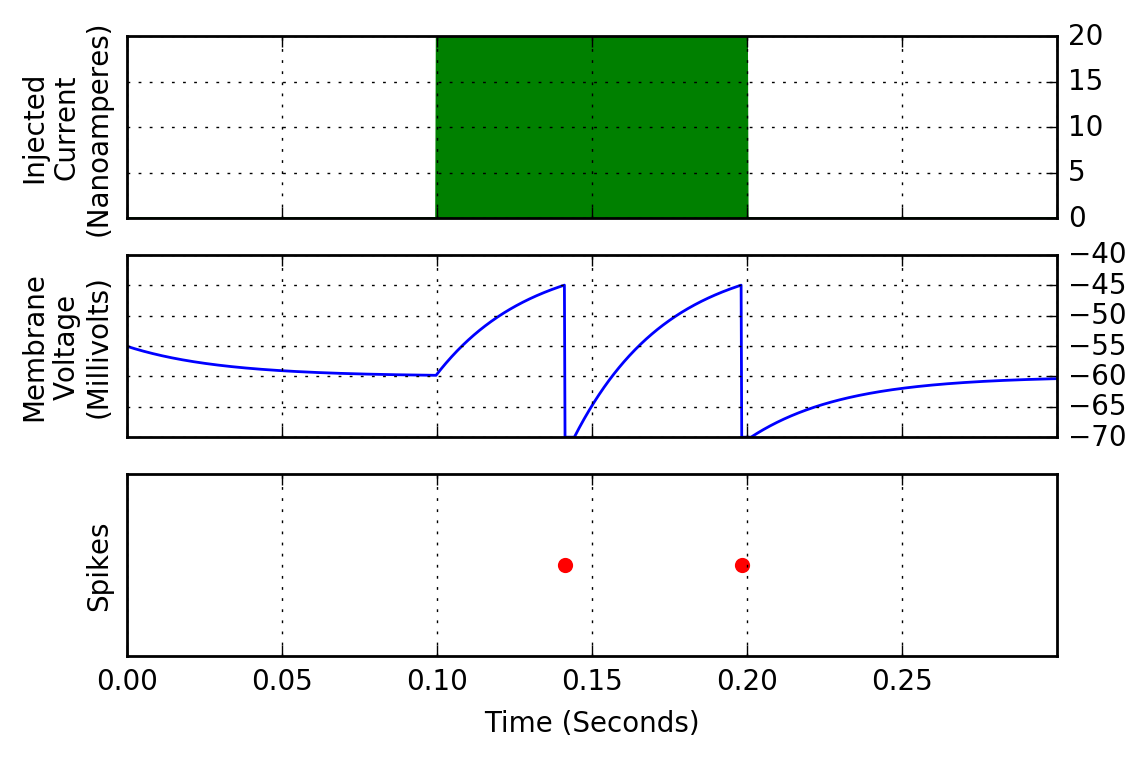

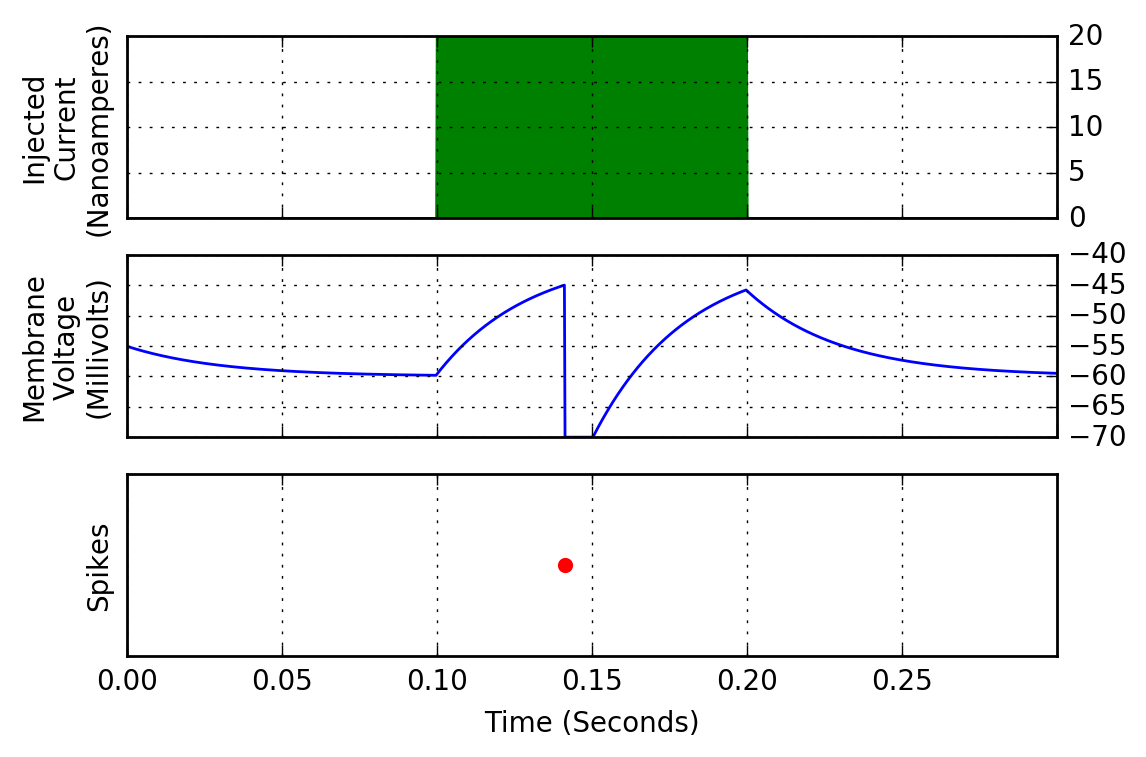

In [29]:
device_id = 1

dt = 2e-4

Iinjects1 = 500 * [0.0]
Iinjects2 = 500 * [2e-8]
Iinjects3 = 500 * [0.0]
Iinjects = np.hstack([Iinjects1, Iinjects2, Iinjects3])

ttl_neuron = 100
par_clcr_pa_t = run_par_clcr_pa(device_id, dt, Iinjects, ttl_neuron, plot = True)

## Workgroup/Workitem Optimization

### Parallel Implementation of OpenCL Loop and Collective Result with Parameter Arrays that Runs On One Workgroup Only (`run_par_clcrwg_pa` Function)

To perform global synchronization, OpenCL requires a running program to exit the kernel. The only barrier function supported in OpenCL is for local synchronization. This function tries to achieve global synchronization using local barrier by making sure that all working items run in a same workgroup.

Many constrains are tied with this implementation. Firstly, it cannot run on all OpenCL devices with following error message.

`LogicError: clEnqueueNDRangeKernel failed: invalid work group size`

Secondly, global item size need to be integer multiplication of local item size. Finally, different devices have different maximum workitems per workgroup that need extra handler.

In [30]:
def run_par_clcrwg_pa(device_id, dt, Iinjects, ttl_neuron, workitem_size = None, plot = False):
    # Setup OpenCL
    cl_device = devices[device_id]
    cl_context = cl_set_context(cl_device)
    cl_queue = cl_set_queue(cl_context, cl_device)
    
    # Automatically define work item size if it is not predefined
    if workitem_size == None:
        max_workitem_size = cl_device.get_info(cl.device_info.MAX_WORK_GROUP_SIZE)
        # Many modern devices have already supported up to 1024 work items per workgroup but
        # some devices only support up to 512.
        if max_workitem_size >= 1000:
            workitem_size = (1000,)
        else:
            workitem_size = (500,)
        if ttl_neuron < workitem_size[0]:
            workitem_size = (ttl_neuron,)
    else:
        workitem_size = (workitem_size,)
    
    # Create neurons
    input_len = len(Iinjects)
    trefracts = np.linspace(3e-3, 9e-3, ttl_neuron)
    lifNeurons = []
    for i in range(ttl_neuron):
        lifNeurons.append(LifNeuron(Vinit = -0.055, Vreset = -0.07, Trefract = trefracts[i]))
    
    # Create OpenCL buffer
    tic = time.time()
    mf = cl.mem_flags
    # Iinjects
    Iinjects_np = np.array(Iinjects, dtype = np.float32)
    Iinjects_buf = cl.Buffer(cl_context, \
                             mf.READ_ONLY | mf.COPY_HOST_PTR, \
                             hostbuf = Iinjects_np)
    # LifNeurons
    lif_Rm_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vresting_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vthresh_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vreset_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vinit_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Vm_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Trefract_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_summationPoint_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_Iinject_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_C1_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_C2_np = np.zeros((ttl_neuron), dtype = np.float32)
    lif_nStepsInRefr_np = np.zeros((ttl_neuron), dtype = np.int32)
    lif_hasFired_np = np.zeros((ttl_neuron), dtype = np.int32)
    
    for lifNeuron_idx, lifNeuron in enumerate(lifNeurons):
        lif_Rm_np[lifNeuron_idx] = lifNeuron.Rm
        lif_Vresting_np[lifNeuron_idx] = lifNeuron.Vresting
        lif_Vthresh_np[lifNeuron_idx] = lifNeuron.Vthresh
        lif_Vreset_np[lifNeuron_idx] = lifNeuron.Vreset
        lif_Vinit_np[lifNeuron_idx] = lifNeuron.Vinit
        lif_Vm_np[lifNeuron_idx] = lifNeuron.Vm
        lif_Trefract_np[lifNeuron_idx] = lifNeuron.Trefract
        lif_summationPoint_np[lifNeuron_idx] = lifNeuron.summationPoint
        lif_Iinject_np[lifNeuron_idx] = lifNeuron.Iinject
        lif_C1_np[lifNeuron_idx] = lifNeuron.C1
        lif_C2_np[lifNeuron_idx] = lifNeuron.C2
        lif_nStepsInRefr_np[lifNeuron_idx] = lifNeuron.nStepsInRefr
        lif_hasFired_np[lifNeuron_idx] = lifNeuron.hasFired
    
    lif_Rm_buf = cl.Buffer(cl_context, \
                           mf.READ_ONLY | mf.COPY_HOST_PTR, \
                           hostbuf = lif_Rm_np)
    lif_Vresting_buf = cl.Buffer(cl_context, \
                                 mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                 hostbuf = lif_Vresting_np)
    lif_Vthresh_buf = cl.Buffer(cl_context, \
                                mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                hostbuf = lif_Vthresh_np)
    lif_Vreset_buf = cl.Buffer(cl_context, \
                               mf.READ_ONLY | mf.COPY_HOST_PTR, \
                               hostbuf = lif_Vreset_np)
    lif_Vinit_buf = cl.Buffer(cl_context, \
                              mf.READ_ONLY | mf.COPY_HOST_PTR, \
                              hostbuf = lif_Vinit_np)
    lif_Vm_buf = cl.Buffer(cl_context, \
                           mf.READ_WRITE | mf.COPY_HOST_PTR, \
                           hostbuf = lif_Vm_np)
    lif_Trefract_buf = cl.Buffer(cl_context, \
                                 mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                 hostbuf = lif_Trefract_np)
    lif_summationPoint_buf = cl.Buffer(cl_context, \
                                       mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                       hostbuf = lif_summationPoint_np)
    lif_Iinject_buf = cl.Buffer(cl_context, \
                                mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                hostbuf = lif_Iinject_np)
    lif_C1_buf = cl.Buffer(cl_context, \
                           mf.READ_ONLY | mf.COPY_HOST_PTR, \
                           hostbuf = lif_C1_np)
    lif_C2_buf = cl.Buffer(cl_context, \
                           mf.READ_ONLY | mf.COPY_HOST_PTR, \
                           hostbuf = lif_C2_np)
    lif_nStepsInRefr_buf = cl.Buffer(cl_context, \
                                     mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                     hostbuf = lif_nStepsInRefr_np)
    lif_hasFired_buf = cl.Buffer(cl_context, \
                                 mf.READ_WRITE | mf.COPY_HOST_PTR, \
                                 hostbuf = lif_hasFired_np)
    # Vms
    Vms_np = np.zeros((ttl_neuron, input_len), dtype = np.float32)
    Vms_buf = cl.Buffer(cl_context, \
                        mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                        hostbuf = Vms_np)
    # Spikes Collection
    spikes_coll_np = np.zeros((ttl_neuron, input_len), dtype = np.int32)
    spikes_coll_buf = cl.Buffer(cl_context, \
                                mf.WRITE_ONLY | mf.COPY_HOST_PTR, \
                                hostbuf = spikes_coll_np)
    toc = time.time()
    # Buffer allocation time
    bat = toc - tic
    
    # Create OpenCL program
    cl_program = cl_create_program(cl_context, cl_device, "./LifNeuron.cl")
    
    # Run
    tic = time.time()
    cl_program.nextState_clcrwg_pa(cl_queue, \
                                   (ttl_neuron,), workitem_size, \
                                   np.float32(dt), \
                                   np.int32(input_len), \
                                   Iinjects_buf, \
                                   lif_Rm_buf, \
                                   lif_Vresting_buf, \
                                   lif_Vthresh_buf, \
                                   lif_Vreset_buf, \
                                   lif_Vinit_buf, \
                                   lif_Vm_buf, \
                                   lif_Trefract_buf, \
                                   lif_summationPoint_buf, \
                                   lif_Iinject_buf, \
                                   lif_C1_buf, \
                                   lif_C2_buf, \
                                   lif_nStepsInRefr_buf, \
                                   lif_hasFired_buf, \
                                   Vms_buf, \
                                   spikes_coll_buf).wait()
    toc = time.time()
    # Run time
    rt = toc - tic
    
    # Collect result
    tic = time.time()
    cl.enqueue_copy(cl_queue, Vms_np, Vms_buf)
    Vms = Vms_np
    
    cl.enqueue_copy(cl_queue, spikes_coll_np, spikes_coll_buf)
    spikes = [[] for i in range(ttl_neuron)]
    for n_idx, spikes_np in enumerate(spikes_coll_np):
        spikes[n_idx] = spikes_np.nonzero()[0] * dt
    toc = time.time()
    # Result collection time
    rct = toc - tic
    
    if plot:
        plot_spikes(dt, Iinjects, Vms[0], spikes[0])
        plot_spikes(dt, Iinjects, Vms[-1], spikes[-1])
    
    # Total time
    tt = bat + rt + rct
    return bat, rt, rct, tt

Testing code plots the first and last neurons.

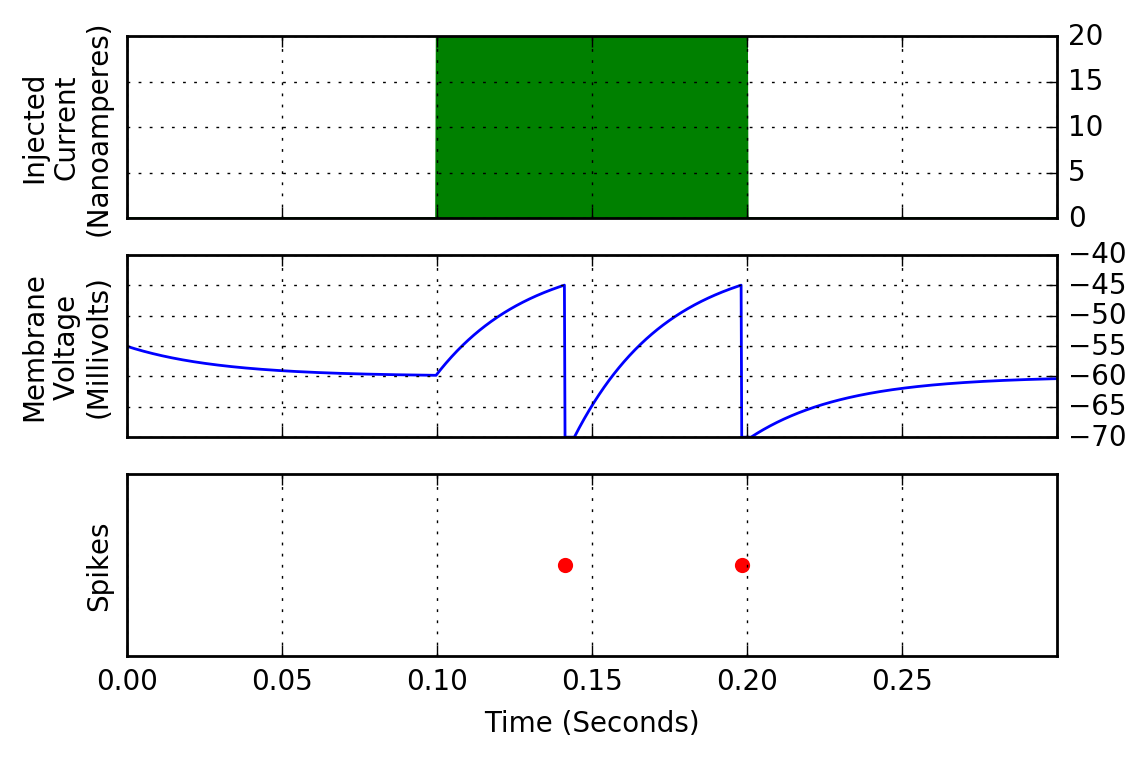

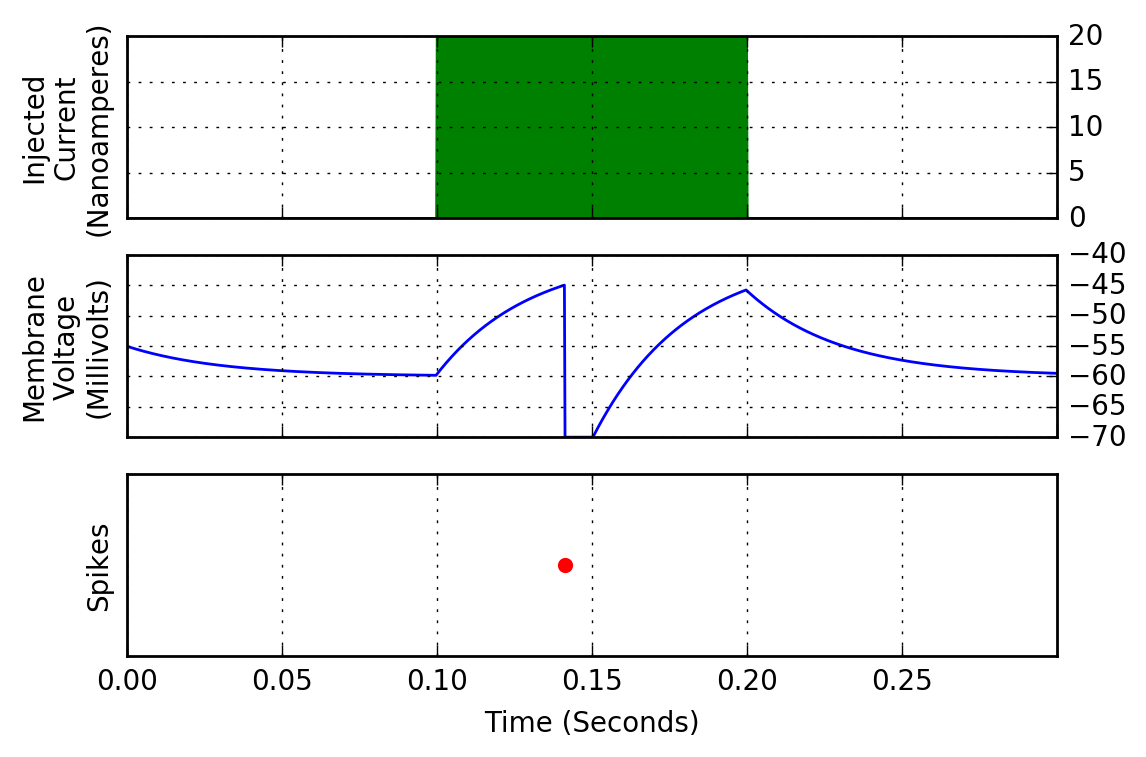

In [31]:
device_id = 1

dt = 2e-4

Iinjects1 = 500 * [0.0]
Iinjects2 = 500 * [2e-8]
Iinjects3 = 500 * [0.0]
Iinjects = np.hstack([Iinjects1, Iinjects2, Iinjects3])

ttl_neuron = 1000
par_clcr_pa_t = run_par_clcrwg_pa(device_id, dt, Iinjects, \
                                  ttl_neuron, workitem_size = 500, \
                                  plot = True)

---

# Execution Time

Following code executes serial and all six parallel implementations on different number of neurons (1, 10, 100, 1 thousand, 10 thousand, 100 thousand, 1 million) and different OpenCL devices supported by this machine. The execution time collected from each implementation consists of buffer allocation time (`bat`), run time (`rt`), result collection time (`rct`) and total time (`tt`) of the three.

In [32]:
dt = 2e-4

Iinjects1 = 500 * [0.0]
Iinjects2 = 500 * [2e-8]
Iinjects3 = 500 * [0.0]
Iinjects = np.hstack([Iinjects1, Iinjects2, Iinjects3])

# Total Neurons
ttl_neurons = [1, 10, 100, 1000, 10000, 100000, 1000000]
ttl_neurons_len = len(ttl_neurons)

# Methods
methods_len = 7
SEQ_ID = 0
PAR_PLIR_ID = 1
PAR_PLCR_ID = 2
PAR_CLCR_ID = 3
PAR_PLCR_PA_ID = 4
PAR_CLCR_PA_ID = 5
PAR_CLCRWG_PA_ID = 6

# Devices
devices_len = len(devices)

# Portions
# Buffer allocation times
bats = np.zeros((devices_len, methods_len, ttl_neurons_len), dtype = np.float32)
# Run times
rts  = np.zeros((devices_len, methods_len, ttl_neurons_len), dtype = np.float32)
# Result collection times
rcts = np.zeros((devices_len, methods_len, ttl_neurons_len), dtype = np.float32)
# Total times
tts  = np.zeros((devices_len, methods_len, ttl_neurons_len), dtype = np.float32)
BAT_ID = 0
RT_ID = 1
RCT_ID = 2
TT_ID = 3

In [32]:
# Run sequential once for every neuron size (ttl_neuron) and 
# save the result in seq_ts
seq_ts = []
# Devices
for device_id, device in enumerate(devices):
    print("Running on %s - %s" % (device.get_info(cl.device_info.VENDOR), \
                                  device.get_info(cl.device_info.NAME)))
    # Total neurons
    for ttl_neuron_id, ttl_neuron in enumerate(ttl_neurons):
        print("    Total neurons", ttl_neuron)
        # Methods
        if device_id == 0:
            # Run sequential once as the baseline
            try:
                seq_t = run_seq(dt, Iinjects, ttl_neuron)
            except:
                seq_t = (np.nan, np.nan, np.nan, np.nan)
            seq_ts.append(seq_t)
        else:
            seq_t = seq_ts[ttl_neuron_id]
        # Python loop and iterative result implementation
        try:
            par_plir_t = run_par_plir(device_id, dt, Iinjects, ttl_neuron)
        except (cl.LogicError, cl.MemoryError, cl.RuntimeError):
            par_plir_t = (np.nan, np.nan, np.nan, np.nan)
        # Python loop and collective result implementation
        try:
            par_plcr_t = run_par_plcr(device_id, dt, Iinjects, ttl_neuron)
        except (cl.LogicError, cl.MemoryError, cl.RuntimeError):
            par_plcr_t = (np.nan, np.nan, np.nan, np.nan)
        # OpenCL loop and collective result implementation
        try:
            par_clcr_t = run_par_clcr(device_id, dt, Iinjects, ttl_neuron)
        except (cl.LogicError, cl.MemoryError, cl.RuntimeError):
            par_clcr_t = (np.nan, np.nan, np.nan, np.nan)
        # Python loop and collective result implementation with 
        # parameter arrays data structure
        try:
            par_plcr_pa_t = run_par_plcr_pa(device_id, dt, Iinjects, ttl_neuron)
        except (cl.LogicError, cl.MemoryError, cl.RuntimeError):
            par_plcr_pa_t = (np.nan, np.nan, np.nan, np.nan)
        # OpenCL loop and collective result implementation with 
        # parameter arrays data structure
        try:
            par_clcr_pa_t = run_par_clcr_pa(device_id, dt, Iinjects, ttl_neuron)
        except (cl.LogicError, cl.MemoryError, cl.RuntimeError):
            par_clcr_pa_t = (np.nan, np.nan, np.nan, np.nan)
        # OpenCL loop and collective result implementation with 
        # parameter arrays data structure runs in a same workgroup
        try:
            par_clcrwg_pa_t = run_par_clcrwg_pa(device_id, dt, Iinjects, ttl_neuron)
        except (cl.LogicError, cl.MemoryError, cl.RuntimeError):
            par_clcrwg_pa_t = (np.nan, np.nan, np.nan, np.nan)
        
        # Portions -> Devices -> Methods -> Total Neurons
        bats[device_id][SEQ_ID][ttl_neuron_id] = seq_t[BAT_ID]
        bats[device_id][PAR_PLIR_ID][ttl_neuron_id] = par_plir_t[BAT_ID]
        bats[device_id][PAR_PLCR_ID][ttl_neuron_id] = par_plcr_t[BAT_ID]
        bats[device_id][PAR_CLCR_ID][ttl_neuron_id] = par_clcr_t[BAT_ID]
        bats[device_id][PAR_PLCR_PA_ID][ttl_neuron_id] = par_plcr_pa_t[BAT_ID]
        bats[device_id][PAR_CLCR_PA_ID][ttl_neuron_id] = par_clcr_pa_t[BAT_ID]
        bats[device_id][PAR_CLCRWG_PA_ID][ttl_neuron_id] = par_clcrwg_pa_t[BAT_ID]
        
        rts[device_id][SEQ_ID][ttl_neuron_id] = seq_t[RT_ID]
        rts[device_id][PAR_PLIR_ID][ttl_neuron_id] = par_plir_t[RT_ID]
        rts[device_id][PAR_PLCR_ID][ttl_neuron_id] = par_plcr_t[RT_ID]
        rts[device_id][PAR_CLCR_ID][ttl_neuron_id] = par_clcr_t[RT_ID]
        rts[device_id][PAR_PLCR_PA_ID][ttl_neuron_id] = par_plcr_pa_t[RT_ID]
        rts[device_id][PAR_CLCR_PA_ID][ttl_neuron_id] = par_clcr_pa_t[RT_ID]
        rts[device_id][PAR_CLCRWG_PA_ID][ttl_neuron_id] = par_clcrwg_pa_t[RT_ID]
        
        rcts[device_id][SEQ_ID][ttl_neuron_id] = seq_t[RCT_ID]
        rcts[device_id][PAR_PLIR_ID][ttl_neuron_id] = par_plir_t[RCT_ID]
        rcts[device_id][PAR_PLCR_ID][ttl_neuron_id] = par_plcr_t[RCT_ID]
        rcts[device_id][PAR_CLCR_ID][ttl_neuron_id] = par_clcr_t[RCT_ID]
        rcts[device_id][PAR_PLCR_PA_ID][ttl_neuron_id] = par_plcr_pa_t[RCT_ID]
        rcts[device_id][PAR_CLCR_PA_ID][ttl_neuron_id] = par_clcr_pa_t[RCT_ID]
        rcts[device_id][PAR_CLCRWG_PA_ID][ttl_neuron_id] = par_clcrwg_pa_t[RCT_ID]
        
        tts[device_id][SEQ_ID][ttl_neuron_id] = seq_t[TT_ID]
        tts[device_id][PAR_PLIR_ID][ttl_neuron_id] = par_plir_t[TT_ID]
        tts[device_id][PAR_PLCR_ID][ttl_neuron_id] = par_plcr_t[TT_ID]
        tts[device_id][PAR_CLCR_ID][ttl_neuron_id] = par_clcr_t[TT_ID]
        tts[device_id][PAR_PLCR_PA_ID][ttl_neuron_id] = par_plcr_pa_t[TT_ID]
        tts[device_id][PAR_CLCR_PA_ID][ttl_neuron_id] = par_clcr_pa_t[TT_ID]
        tts[device_id][PAR_CLCRWG_PA_ID][ttl_neuron_id] = par_clcrwg_pa_t[TT_ID]
        

Running on Intel - Intel(R) Core(TM) i7-3615QM CPU @ 2.30GHz
    Total neurons 1
    Total neurons 10
    Total neurons 100
    Total neurons 1000
    Total neurons 10000
Running on Intel - HD Graphics 4000
    Total neurons 1
    Total neurons 10
    Total neurons 100
    Total neurons 1000
    Total neurons 10000
Running on NVIDIA - GeForce GT 650M
    Total neurons 1
    Total neurons 10
    Total neurons 100
    Total neurons 1000
    Total neurons 10000


Save execution time result into `Benchmark` directory.

In [33]:
machine_name = "mac"

save_list("Benchmark/exec_time_%s_device_names.txt" % machine_name, device_names)
np.save("Benchmark/exec_time_%s_bats.npy" % machine_name, bats)
np.save("Benchmark/exec_time_%s_rts.npy" % machine_name, rts)
np.save("Benchmark/exec_time_%s_rcts.npy" % machine_name, rcts)
np.save("Benchmark/exec_time_%s_tts.npy" % machine_name, tts)

Load and plot execution time of following devices from different machines.

- Mac:
    - Intel(R) Core(TM) i7-3615QM CPU @ 2.30GHz
    - HD Graphics 4000
    - GeForce GT 650M

- PC:
    - Intel(R) Core(TM) i7-4770K CPU @ 3.50GHz
    - GeForce GTX 780

- Server:
    - AMD Opteron(tm) Processor 6380

In [33]:
machine_names = ["mac", "pc", "server"]

device_names_cmb = []
bats_cmb = []
rts_cmb = []
rcts_cmb = []
tts_cmb = []

for machine_name in machine_names:
    if os.path.isfile("Benchmark/exec_time_%s_device_names.txt" % machine_name):
        device_names_cmb += load_list("Benchmark/exec_time_%s_device_names.txt" % machine_name)
        bats_cmb.append(np.load("Benchmark/exec_time_%s_bats.npy" % machine_name))
        rts_cmb.append(np.load("Benchmark/exec_time_%s_rts.npy" % machine_name))
        rcts_cmb.append(np.load("Benchmark/exec_time_%s_rcts.npy" % machine_name))
        tts_cmb.append(np.load("Benchmark/exec_time_%s_tts.npy" % machine_name))
    
bats_cmb = np.concatenate(bats_cmb)
rts_cmb = np.concatenate(rts_cmb)
rcts_cmb = np.concatenate(rcts_cmb)
tts_cmb = np.concatenate(tts_cmb)

Following collective plots on execution time over different number of neurons shows that lower execution time is better. Compared to parallel implementations, the time taken by sequential implementation (`seq` in red) increases more rapidly. Over couple hundreds of neurons, parallel codes start performing better even with both buffer allocation time and result collection time.

Two execution time portions related to memory access; buffer allocation time and result collection time, generally consume similar execution time among different parallel implementations. These portions do object-oriented to parallel data structure convertion and vice versa. Therefore, they are not applicable for sequential implementation.

On the run time portion, one thing stood up is the parallel implementations in which the iteration done in OpenCL (`par_clcr` in magenta, `par_clcr_pa` in orange and `par_clcrwg_pa` in gray). At one thousand neurons or lesser, they perform 10 to 100 times faster than other parallel counterparts (`par_plir` in green, `par_plcr` in blue and `par_plcr_pa` in cyan) before closing up at 10 thousand neurons. As we have the run time comparison between transferring the result (Vm and spike) iteratively (`par_plir` in green) and collectively (`par_plcr` in blue), we can conclude that data transfer does not play important role in increasing execution time. So the only remaining is that triggering OpenCL code from Python in every iteration consumes a lot of time.

Up to now, there is no global (between workgroups) synchronization for OpenCL but only local (within workgroup) synchronization using workgroup barrier function.[3] Please refer to following figure for both global and workgroup barriers. The only way to perform synchronization globally is by exiting OpenCL code (kernel) in which Python needs to trigger the kernel back for subsequent iteration. In this code example, each neuron has no connection to the others so global synchronization is not required. But, in a complete model of interconnected neurons, global synchronization is mandatory before performing synaptic calculation between neurons. The lack of OpenCL global sychronization function that refrains iterations to be done in OpenCL code becomes a major drawback in computing performance.

<center><br>
<img src="https://raw.github.com/ekaakurniawan/3nb/master/Neuron%20Models/LifNeuron/Images/Workgroup%20and%20Global%20Barriers.png" width=500 />
<br>
<i>Local Synchronization in OpenCL Using Workgroup Barrier Function Whereas Global Synchronization or Barrier Can Only Be Done by Exiting OpenCL Code (Kernel)</i>
</center><br>

Nevertheless, there are three parallel implementations sutiable for interconnected neurons. Firstly, for network size of one thousand neurons or lesser, we can use OpenCL loop and collective result runs on a same workgroup (`par_clcrwg_pa` in gray). On this, we can treat local synchronization as global barrier bacause all neurons run on the same workgroup. The limitations to this are current devices only support up to 1024 workitems per workgroup and the implementation itself does not work on all OpenCL devices. Secondly, for a network with tens of thousands neurons, we can still use Python loop implementations like `par_plcr_pa` in cyan as the fastest among some other Python loop implementations especially when using high-end GPU device with thousands of shaders. The limitation to this second approach is that GPU has very limited dedicated global memory (up to 8 GB only). Finally, for a larger network with one million neurons, we can use Python loop implementations (`par_plcr_pa` in cyan) with a cluster of CPUs (up to 32 cores or 64 threads) and large amount of memory (up to 128 GB). With this network size cascade in mind, each of the parallel implementations can acheive speedup of hundreds of folds compared to sequential Python implementation.

Please note that sequential Python implementation as the baseline in this study is slower than C implementation. Also, the neuron term used in this document is solely the soma portion of a complete neuron without the axon and synapse portions. The synapse model is conducted on different study.

For data structure comparison, "parameter arrays" performs faster if not comparable against "neurons array" data structure.

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


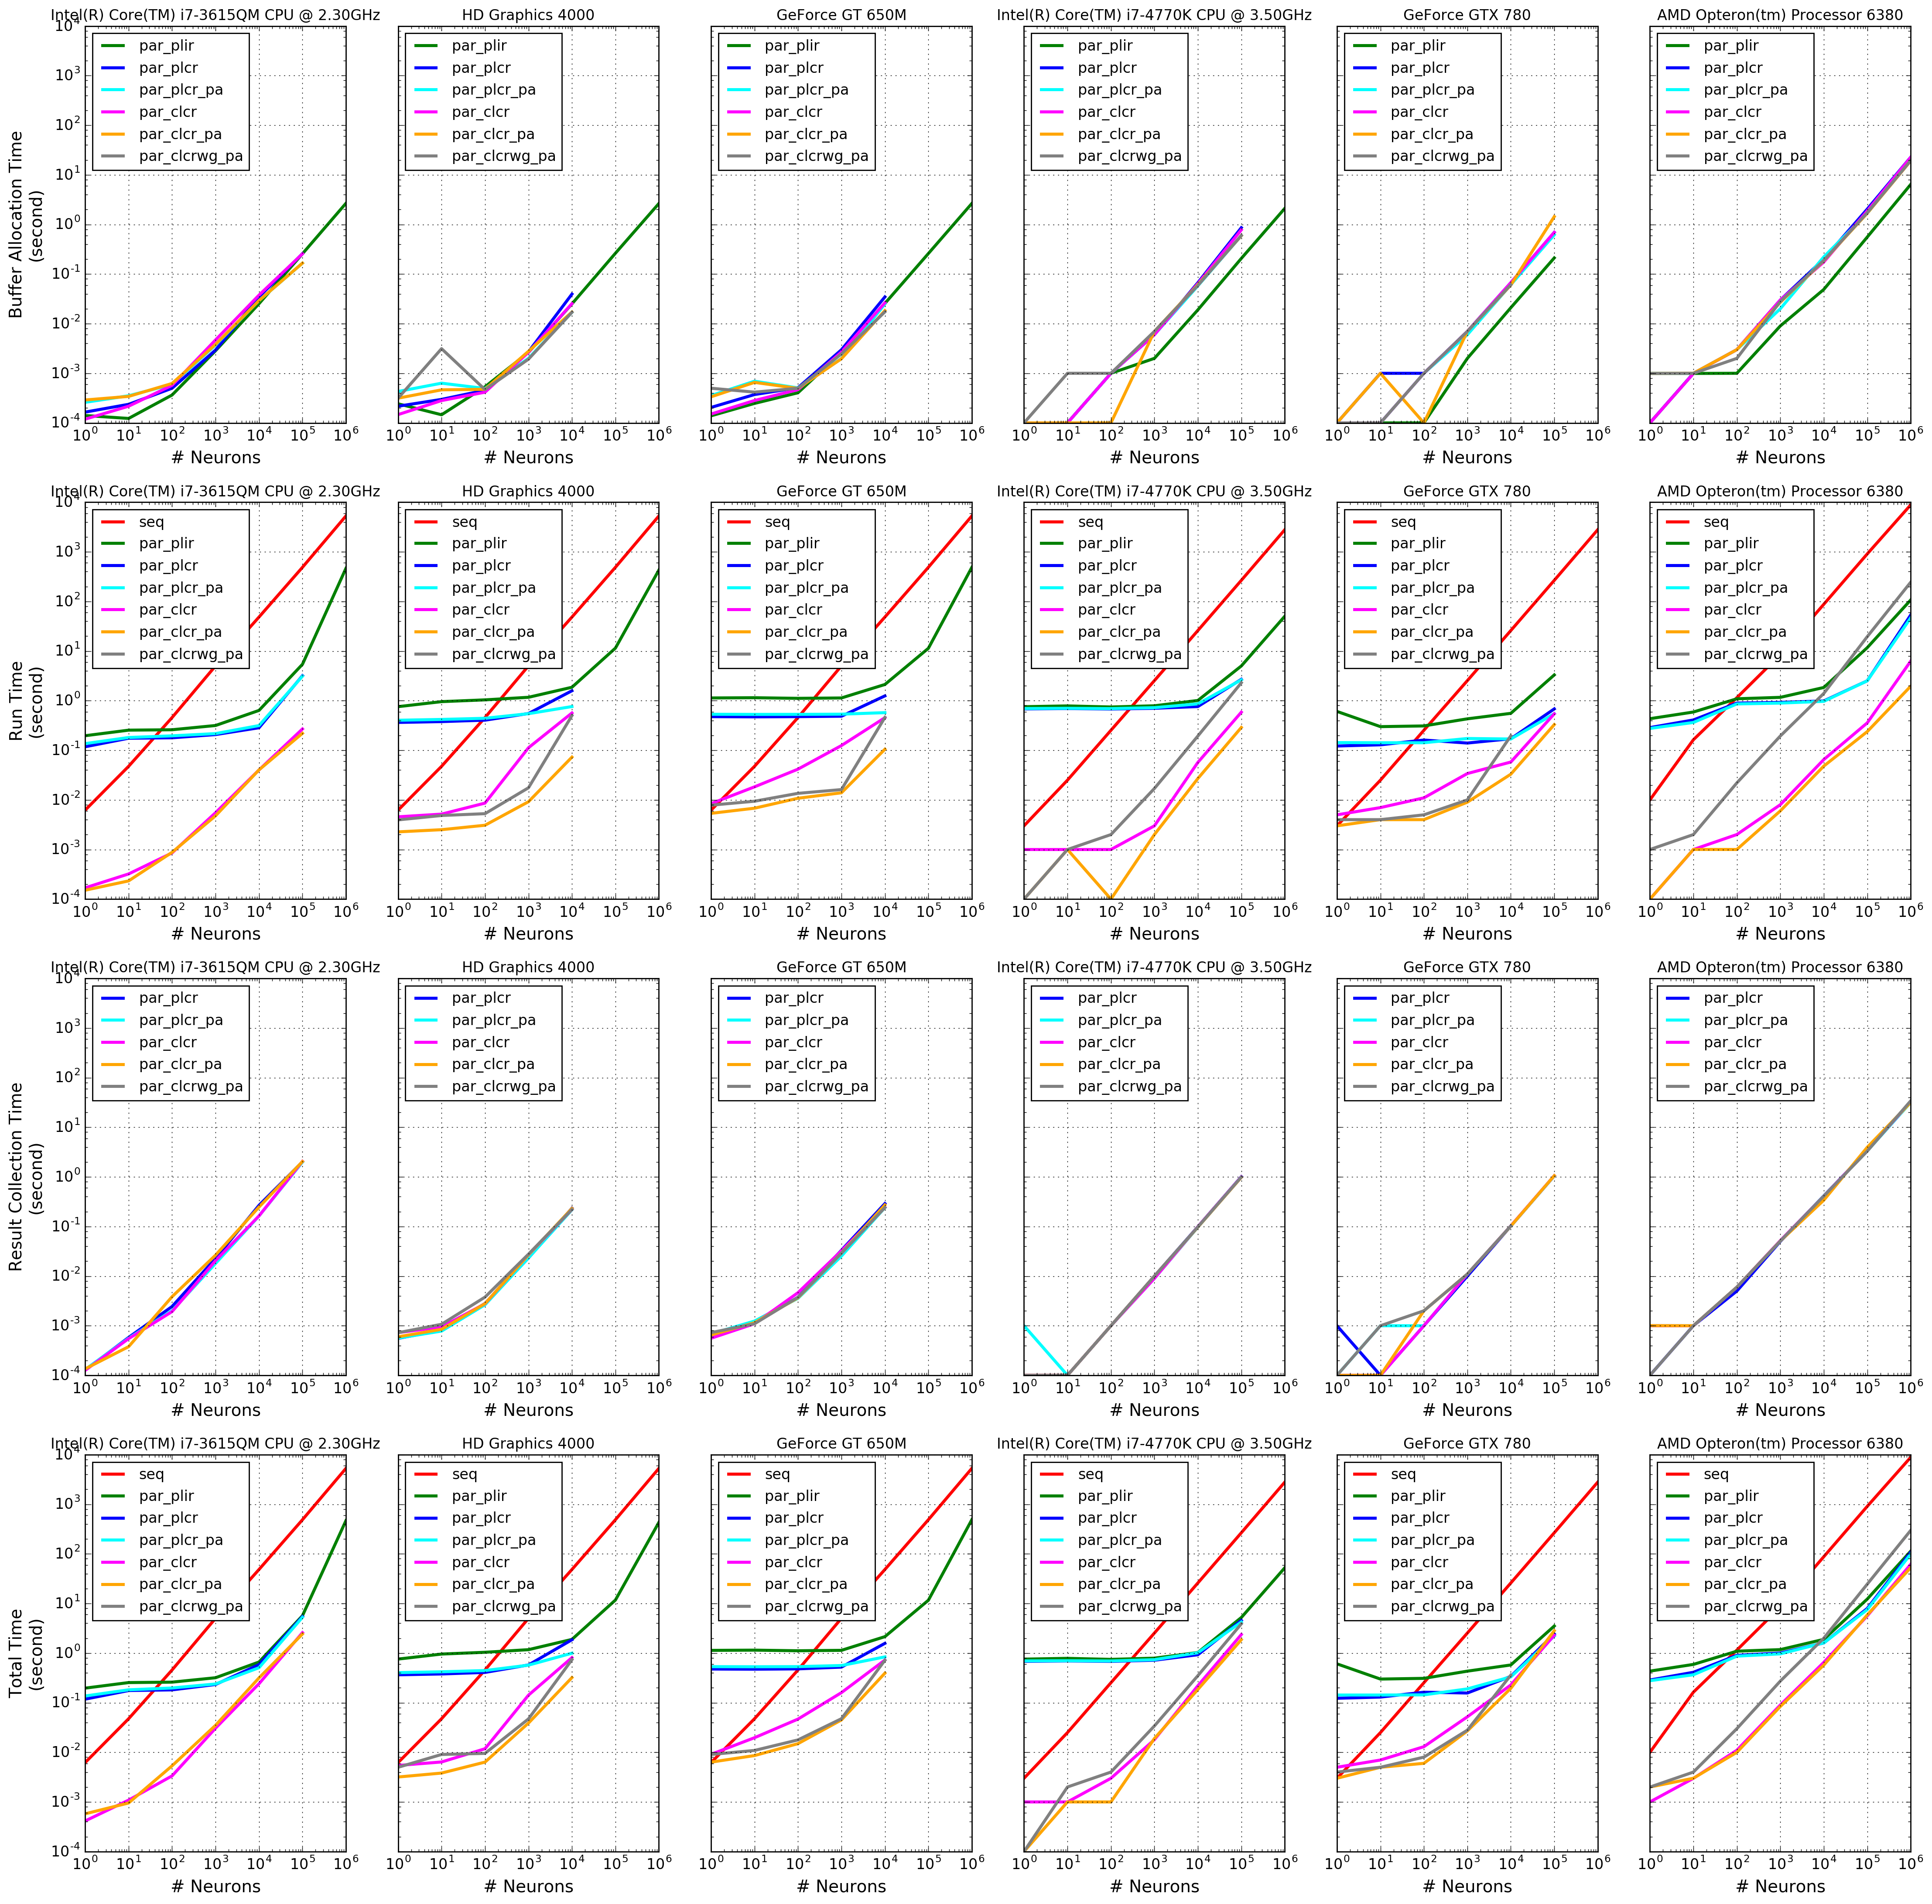

In [34]:
plot_exec_time(bats_cmb, rts_cmb, rcts_cmb, tts_cmb, device_names_cmb, \
               methods_len, \
               SEQ_ID, PAR_PLIR_ID, PAR_PLCR_ID, PAR_CLCR_ID, \
               PAR_PLCR_PA_ID, PAR_CLCR_PA_ID, PAR_CLCRWG_PA_ID, \
               ttl_neurons)

Following are hardware and software specifications of all devices.

- Intel(R) Core(TM) i7-3615QM CPU @ 2.30GHz
    - Apple OS X 10.9 64-bit
    - 8 GB 1600 MHz DDR3 Memory
    - Intel(R) Core(TM) i7-3615QM CPU @ 2.30GHz, 4 Cores, 8 Threads


- HD Graphics 4000
    - Apple OS X 10.9 64-bit
    - 8 GB 1600 MHz DDR3 Memory
    - Intel(R) Core(TM) i7-3615QM CPU @ 2.30GHz, 4 Cores, 8 Threads
    - Intel HD Graphics 4000, 1024 MB


- GeForce GT 650M
    - Apple OS X 10.9 64-bit
    - 8 GB 1600 MHz DDR3 Memory
    - Intel(R) Core(TM) i7-3615QM CPU @ 2.30GHz, 4 Cores, 8 Threads
    - NVIDIA GeForce GT 650M, 1024 MB, 384 Shaders


- Intel(R) Core(TM) i7-4770K CPU @ 3.50GHz
    - Microsoft Windows 7 Professional 64-bit
    - 16 GB Memory
    - Intel(R) Core(TM) i7-4770K CPU @ 3.50GHz, 4 Cores, 8 Threads


- GeForce GTX 780
    - Microsoft Windows 7 Professional 64-bit
    - 16 GB Memory
    - Intel(R) Core(TM) i7-4770K CPU @ 3.50GHz, 4 Cores, 8 Threads
    - NVIDIA GeForce GTX 780, 3 GB, 2304 Shaders
    

- AMD Opteron(tm) Processor 6380
    - Microsoft Windows Server 2012 64-bit
    - AMD Opteron(tm) Processor 6380 2.50GHz, 32 Cores, 64 Threads
    - 128 GB Memory

---

# Iteration Time

As pointed out when experimenting with execution time, Python iteration is the one consumes most of the time. Following code collects run time of different iterations to know how the run time scales up as the number of iterations increased. The method used is Python iteration and collective result with parameter arrays (`par_plcr_pa`) and neuron size of 10,000.

In [35]:
dt = 2e-4
Iinjects = np.ones(10000) * 2e-8
ttl_neuron = 10000

# Total Iterations
ttl_iterations = [1, 10, 100, 1000, 10000]
ttl_iterations_len = len(ttl_iterations)

# Devices
devices_len = len(devices)

# Run times of different iterations
par_it_rts  = np.zeros((devices_len, ttl_iterations_len), dtype = np.float32)
RT_ID = 1

# Sequential
seq_it_rts = []
for ttl_iteration in ttl_iterations:
    seq_et = run_seq(dt, Iinjects[:ttl_iteration], ttl_neuron)
    seq_it_rts.append(seq_et[RT_ID])

# Devices
for device_id, device in enumerate(devices):
    # Total iterations
    for ttl_iteration_id, ttl_iteration in enumerate(ttl_iterations):
        try:
            par_plcr_pa_t = run_par_plcr_pa(device_id, dt, Iinjects[:ttl_iteration], ttl_neuron)
        except (cl.LogicError, cl.MemoryError, cl.RuntimeError):
            par_plcr_pa_t = (np.nan, np.nan, np.nan, np.nan)
        # Devices -> Total Neurons
        par_it_rts[device_id][ttl_iteration_id] = par_plcr_pa_t[RT_ID]

On fix number of neurons, the runtime increases linearly with number of iterations as shown in following plot.

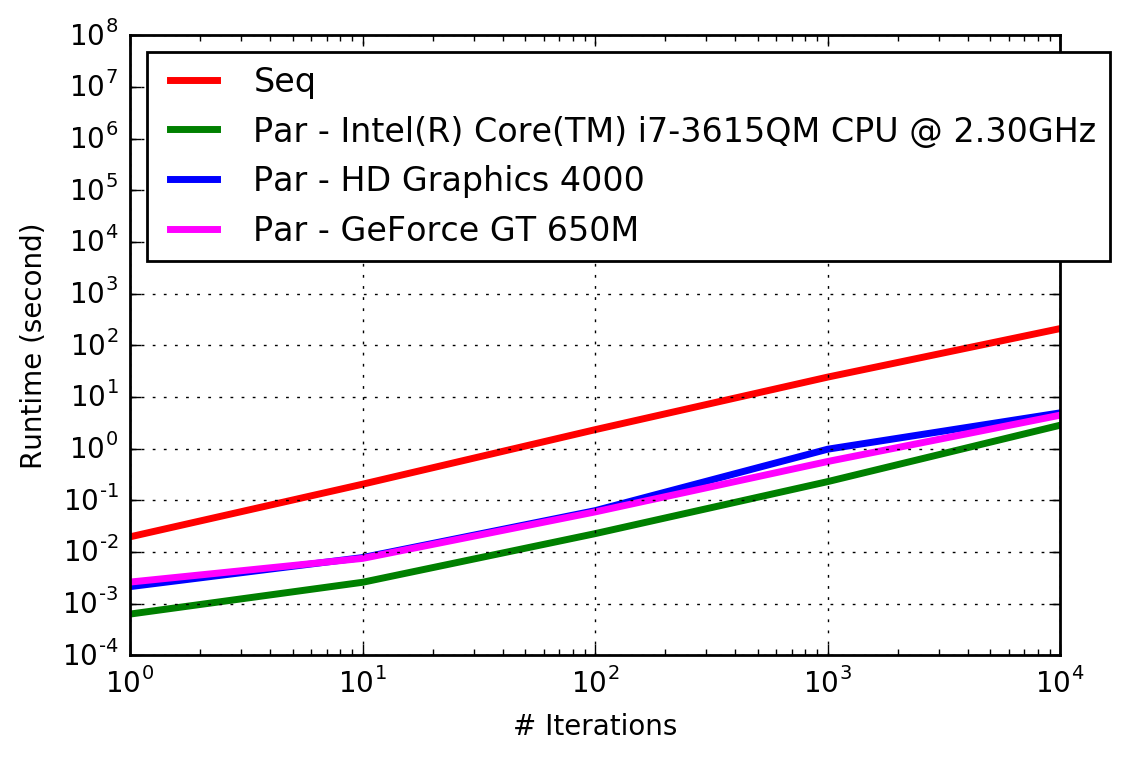

In [36]:
plot_iter_time(seq_it_rts, par_it_rts, device_names, ttl_iterations)

---

# Workitem Size Run Time

Perform experiment with different workitems per wokgroup that optimizes run time.

In [37]:
dt = 2e-4

Iinjects1 = 500 * [0.0]
Iinjects2 = 500 * [2e-8]
Iinjects3 = 500 * [0.0]
Iinjects = np.hstack([Iinjects1, Iinjects2, Iinjects3])

# Total Neurons
ttl_neuron = 10240

# Workitem Sizes
workitem_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
workitem_sizes_len = len(workitem_sizes)

# Devices
devices_len = len(devices)

# Portions
# Run times
par_ws_rts  = np.zeros((devices_len, workitem_sizes_len), dtype = np.float32)
RT_ID = 1

# Devices
for device_id, device in enumerate(devices):
    # Workitem Sizes
    for workitem_size_id, workitem_size in enumerate(workitem_sizes):
        try:
            par_plcr_pa_t = run_par_plcr_pa(device_id, dt, Iinjects, \
                                            ttl_neuron, workitem_size = workitem_size)
        except (cl.LogicError, cl.MemoryError, cl.RuntimeError):
            par_plcr_pa_t = (np.nan, np.nan, np.nan, np.nan)
        # Devices -> Workitem Sizes
        par_ws_rts[device_id][workitem_size_id] = par_plcr_pa_t[RT_ID]

Following figure shows that 4 cores CPU (`Intel(R) Core(TM) i7-3615QM CPU @ 2.30GHz` in green) starts producing good result with 4 or more workitems per workgroup. Whereas the dedicated GPU (`GeForce GT 650M` in magenta) starts at 16 or 32 workitems.

There is no run time reported for workitem size above maximum workitems per workgroup supported by the device.

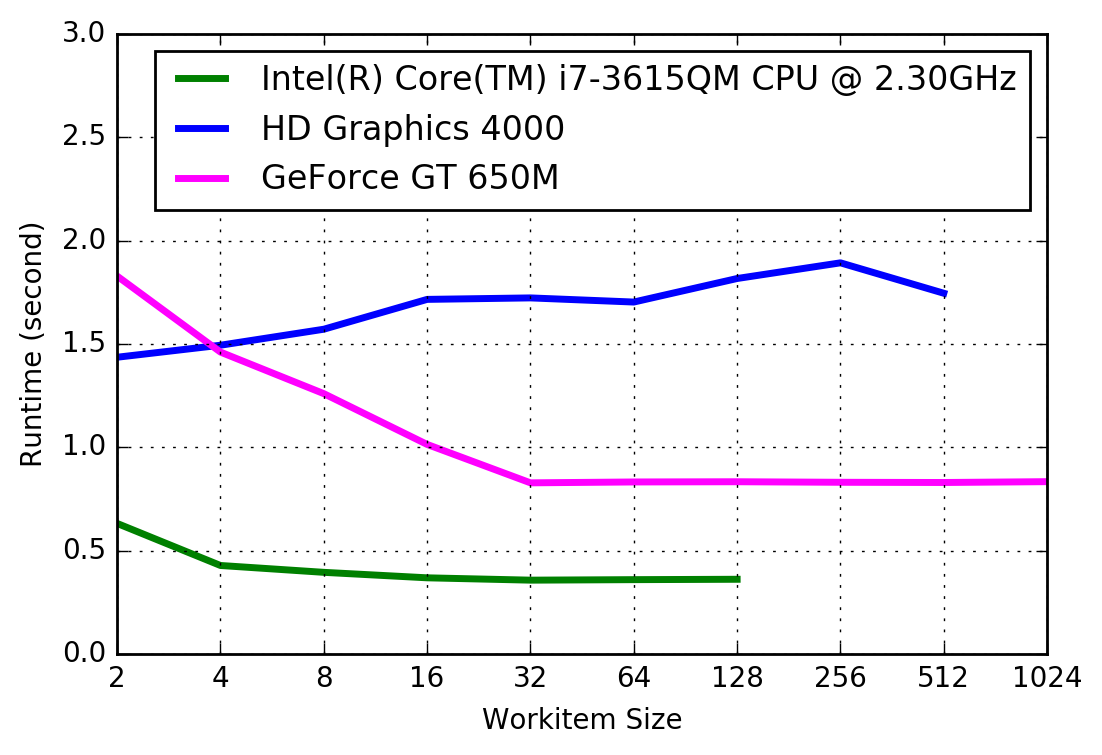

In [38]:
plot_workitem_size_runtime(par_ws_rts, device_names, workitem_sizes)

---

# References

1. Hochbruck, M. & Ostermann A., 2010. Exponential integrators. _Acta Numerica_, 19, pp.209-286. Cambridge University Press. http://dx.doi.org/10.1017/S0962492910000048
2. [CSIM: A neural Circuit SIMulator](http://www.lsm.tugraz.at/csim/index.html)
3. Munshi, A., 2012. _The OpenCL Specification Version: 1.2_, p.30. Khronos OpenCL Working Group.